## NYC 뉴욕 택시 데이터 EDA
- 시간 별 택시 호출 빈도는?
- 요일 별 택시 호출 빈도는?

In [1]:
# !pip3 install chart_studio cufflinks pandas-gbq -U
# !pip install six==1.13.0
# !pip install google-auth==1.19.1

ERROR: google-api-core 1.22.1 has requirement google-auth<2.0dev,>=1.19.1, but you'll have google-auth 1.17.2 which is incompatible.
ERROR: google-cloud-bigquery 1.26.1 has requirement six<2.0.0dev,>=1.13.0, but you'll have six 1.12.0 which is incompatible.


  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=68729 sha256=4f1d08f8aa07d268a8218a3d5615419761379d5d6960eab7ef8a0a0fc3c4860c
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\e1\27\13\3fe67fa7ea7be444b831d117220b3b586b872c9acd4df480d0
Successfully built cufflinks


In [1]:
import chart_studio.plotly as py
import cufflinks as cf    # wrapper
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
print(cf.__version__)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
cf.go_offline()

0.17.3


### 1월의 전체 Trip 빈도

In [2]:
%%time
# google cloud bigquery SQL
query = """
SELECT 
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    count(*) as cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query=query, dialect='standard', project_id='nyc-taxi-demand', auth_local_webserver=True)

Downloading: 100%|███████████████████████| 744/744 [00:00<00:00, 1307.48rows/s]

Wall time: 16.1 s


In [3]:
df.head()

,pickup_hour,cnt
0,2015-01-01 00:00:00,28312
1,2015-01-01 01:00:00,31707
2,2015-01-01 02:00:00,28068
3,2015-01-01 03:00:00,24288
4,2015-01-01 04:00:00,17081


In [4]:
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])

In [5]:
df = df.set_index('pickup_hour')

In [6]:
df.iplot(kind='scatter',xTitle='Datetimes',yTitle='Demand',title='NYC Taxi Demand(2015-01)')

- Jan 27, 2015 02:00에 급격히 하락한 건수
    - 2015년 1월 23일에 큰 눈폭풍이 발생해 26.8인치 만큼의 눈이 옴
    - 전체 택시 trip 횟수가 크게 감소
    - [Wikipedia](https://en.wikipedia.org/wiki/January_2015_North_American_blizzard)

### 일자 별 Trip 빈도

In [7]:
df['date'] = df.index.date  # 일자 추출

In [8]:
df

,cnt,date
pickup_hour,,
2015-01-01 00:00:00,28312,2015-01-01
2015-01-01 01:00:00,31707,2015-01-01
2015-01-01 02:00:00,28068,2015-01-01
2015-01-01 03:00:00,24288,2015-01-01
2015-01-01 04:00:00,17081,2015-01-01
...,...,...
2015-01-31 19:00:00,32436,2015-01-31
2015-01-31 20:00:00,27555,2015-01-31
2015-01-31 21:00:00,27477,2015-01-31


In [9]:
df.groupby(['date'])['cnt'].sum().iplot()

### 요일 별, 시간대 별 Trip 빈도

In [10]:
df['weekday'] = df.index.weekday  # 0 ~ 6 (월 ~ 일)
df['hour'] = df.index.hour  # 시간 단위
df['weeknum'] = df.index.week  # 1 ~ 4 or 5(1주차 ~ 4 or 5주차)

In [11]:
df.tail()

,cnt,date,weekday,hour,weeknum
pickup_hour,,,,,
2015-01-31 19:00:00,32436,2015-01-31,5,19,5
2015-01-31 20:00:00,27555,2015-01-31,5,20,5
2015-01-31 21:00:00,27477,2015-01-31,5,21,5
2015-01-31 22:00:00,29862,2015-01-31,5,22,5
2015-01-31 23:00:00,29856,2015-01-31,5,23,5


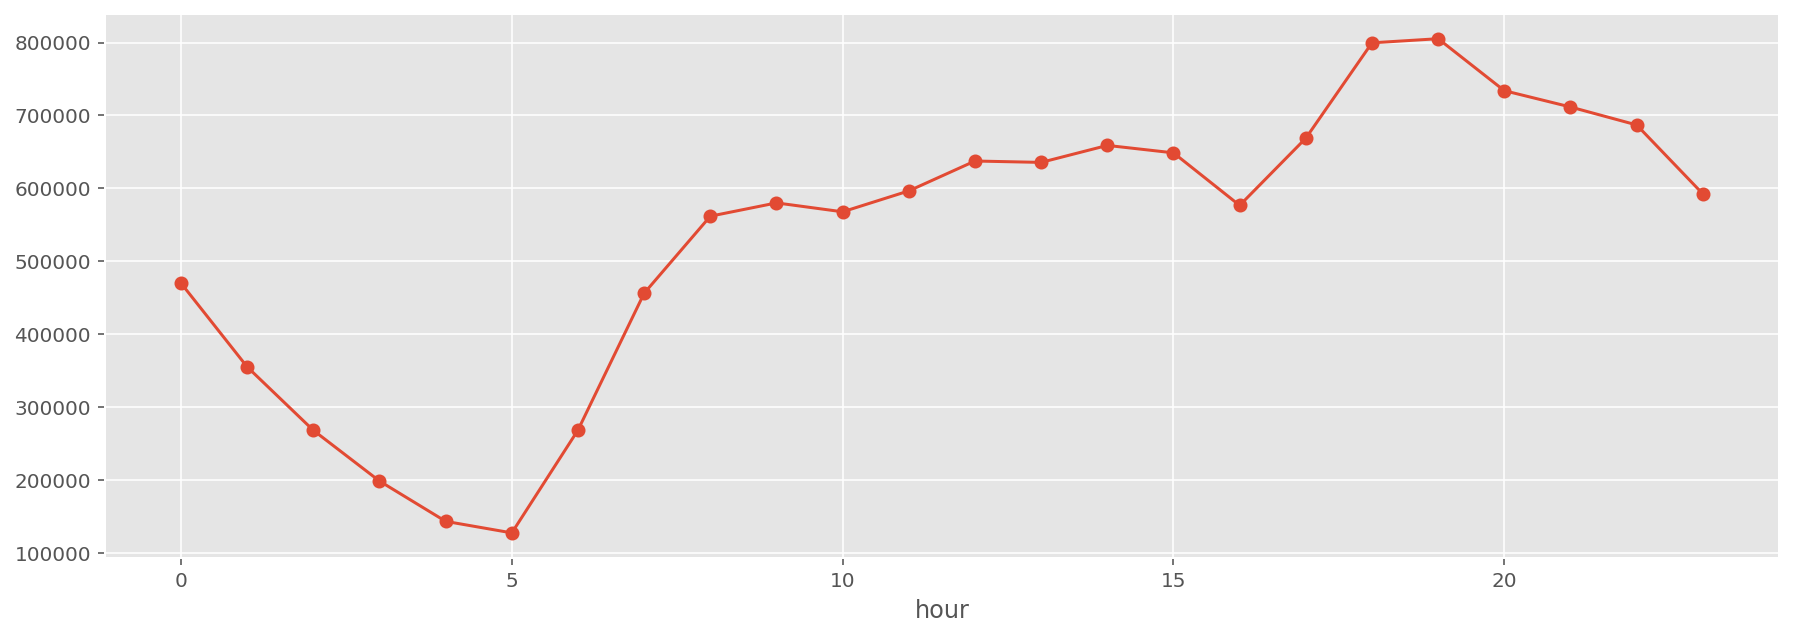

In [12]:
# 시간대 별 Trip 빈도
df.groupby('hour')['cnt'].sum().plot(x='hour', y='cnt', kind='line', style="-o", figsize=(15,5));

- Peak : 18~19
- Off-peak : 5

In [13]:
df.groupby(['hour', 'weekday'])['cnt'].mean()

hour  weekday
0     0           8552.75
      1           6719.25
      2           8787.00
      3          14326.40
      4          14054.20
                   ...   
23    2          17168.75
      3          20464.00
      4          27606.00
      5          28303.00
      6          12062.25
Name: cnt, Length: 168, dtype: float64

In [14]:
# 시간 별, 일 별 Trip 빈도
df.groupby(['hour', 'weekday'])['cnt'].mean().unstack(level=1).iplot()  

### 평일, 주말 별 Trip 수

In [15]:
df['is_weekend'] = ((pd.DatetimeIndex(df.index).dayofweek) // 5 == 1).astype(int)

In [16]:
df.tail(10)

,cnt,date,weekday,hour,weeknum,is_weekend
pickup_hour,,,,,,
2015-01-31 14:00:00,25059,2015-01-31,5,14,5,1
2015-01-31 15:00:00,25886,2015-01-31,5,15,5,1
2015-01-31 16:00:00,23822,2015-01-31,5,16,5,1
2015-01-31 17:00:00,25794,2015-01-31,5,17,5,1
2015-01-31 18:00:00,30804,2015-01-31,5,18,5,1
2015-01-31 19:00:00,32436,2015-01-31,5,19,5,1
2015-01-31 20:00:00,27555,2015-01-31,5,20,5,1
2015-01-31 21:00:00,27477,2015-01-31,5,21,5,1
2015-01-31 22:00:00,29862,2015-01-31,5,22,5,1


In [17]:
# 시간 별, 평일/주말 별 Trip 빈도
df.groupby(['hour', 'is_weekend'])['cnt'].mean().unstack(level=1).iplot()

### 요일 별, 시간대 별 heatmap

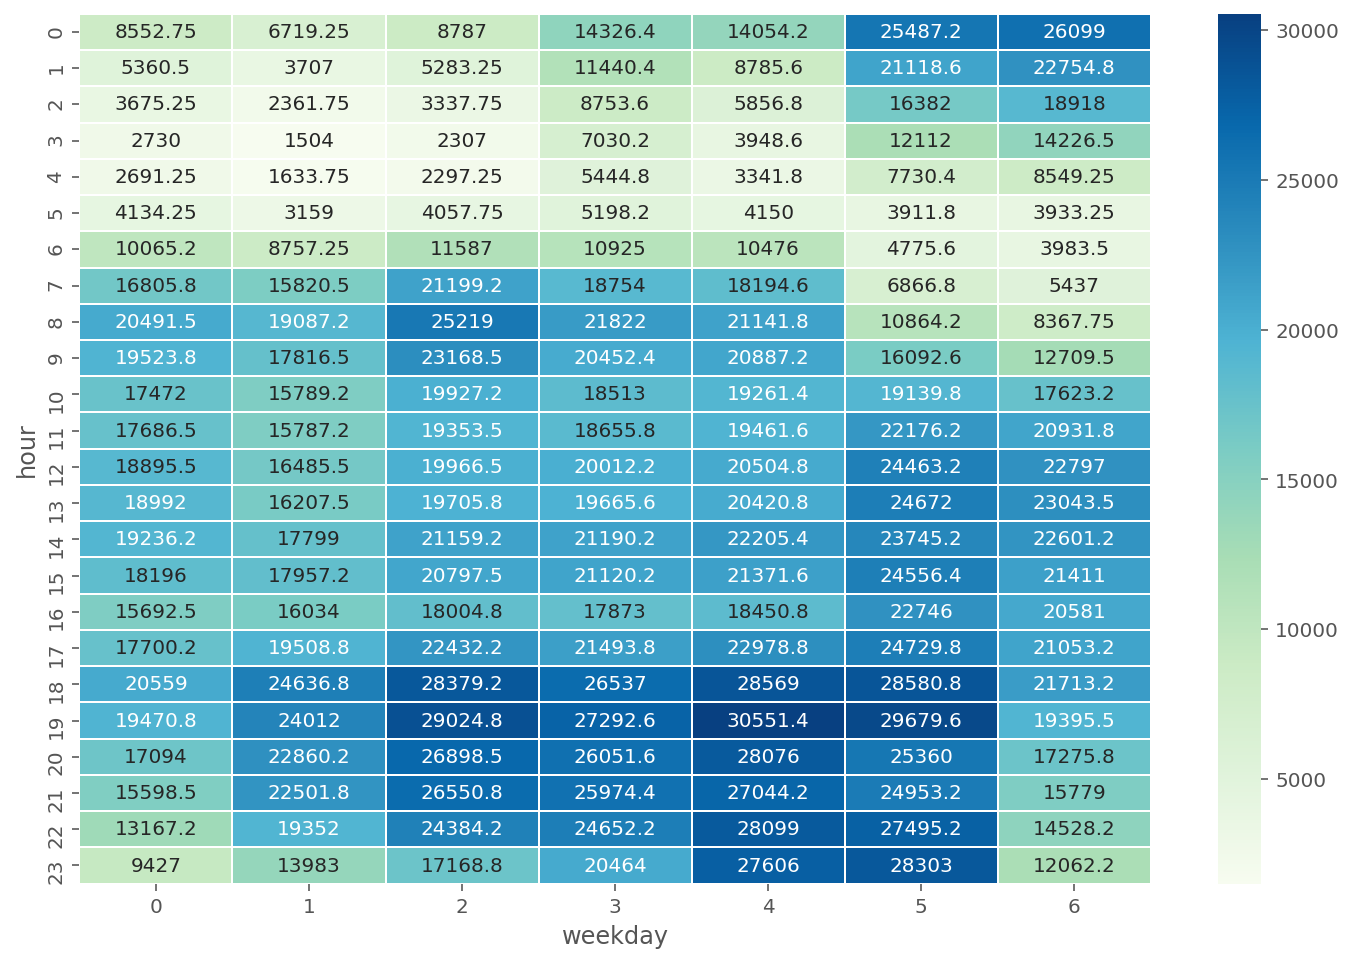

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df.groupby(['hour', 'weekday'])['cnt'].mean().unstack(level=1),
           lw=.5, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':10})

- 금요일 오후부터 빈도 수 증가

In [19]:
data = df.groupby(['weekday', 'hour']).mean()['cnt'].unstack(level=0).reset_index()
# pandas.melt() : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html
data = data.melt(id_vars="hour", value_vars=[0,1,2,3,4,5,6], value_name='cnt')
data.head(10)

,hour,weekday,cnt
0,0,0,8552.75
1,1,0,5360.50
2,2,0,3675.25
3,3,0,2730.00
4,4,0,2691.25
5,5,0,4134.25
6,6,0,10065.25
7,7,0,16805.75
8,8,0,20491.50
9,9,0,19523.75


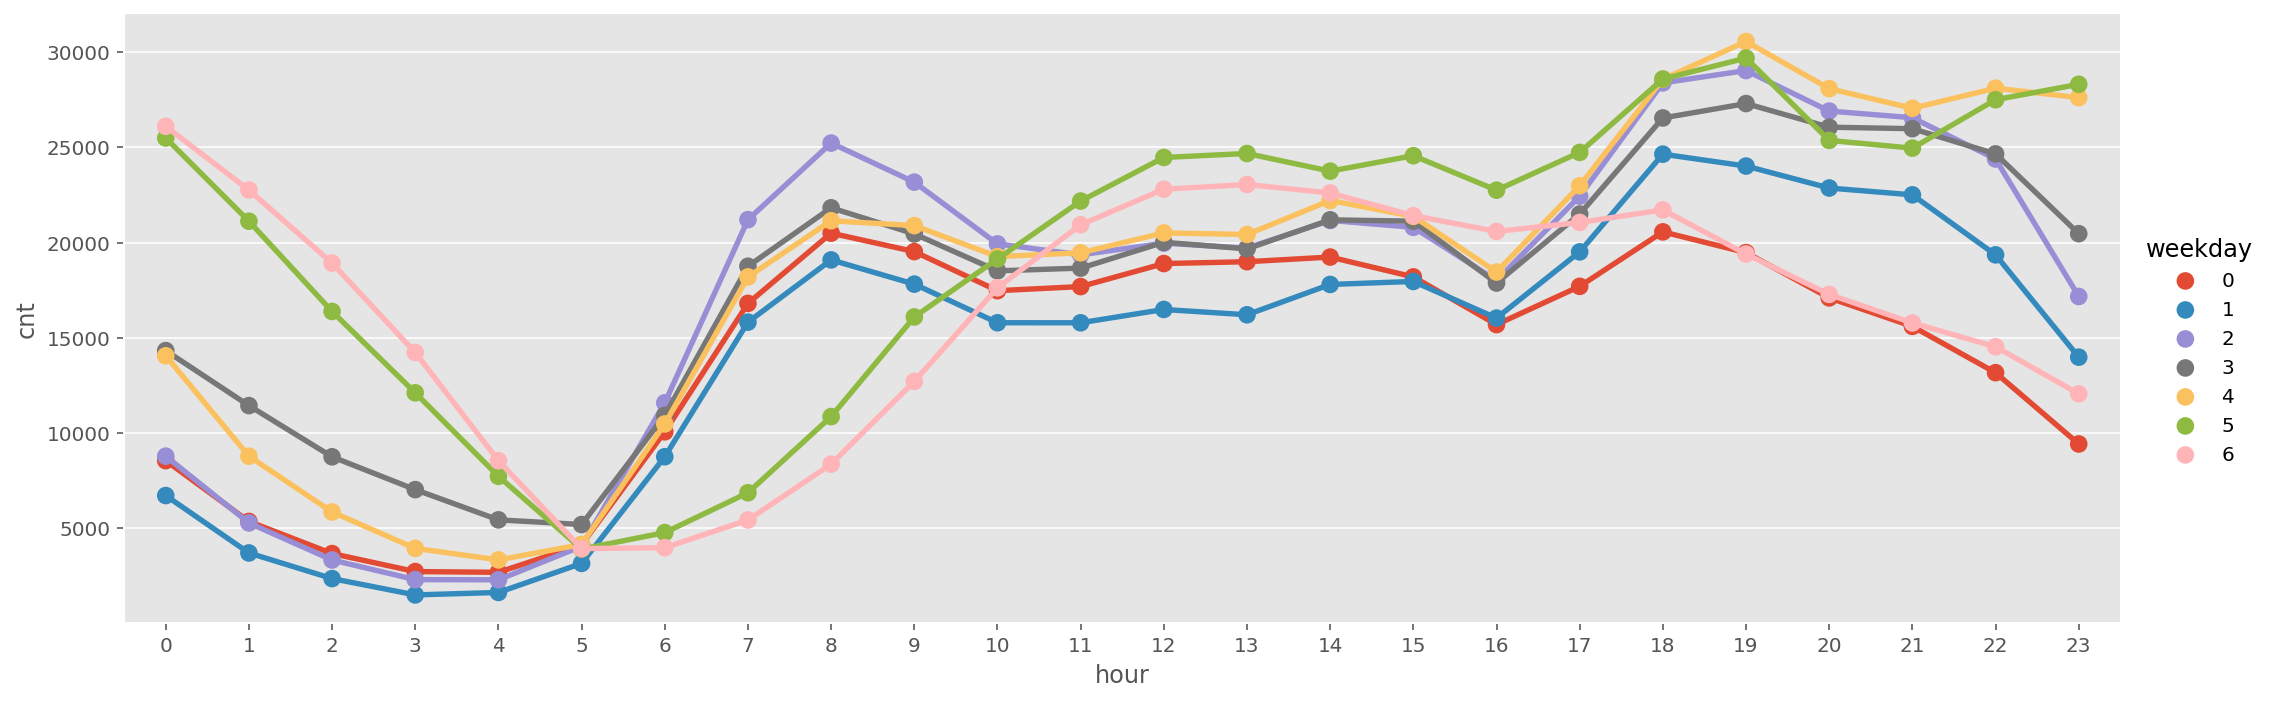

In [28]:
sns.factorplot(x="hour", y='cnt', hue="weekday", data=data, height=5, aspect=3)

### Boxplot
- [Understanding Boxplots](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)

Text(0.5, 1.0, 'Hourly Box Plot(2015-01 Data)')

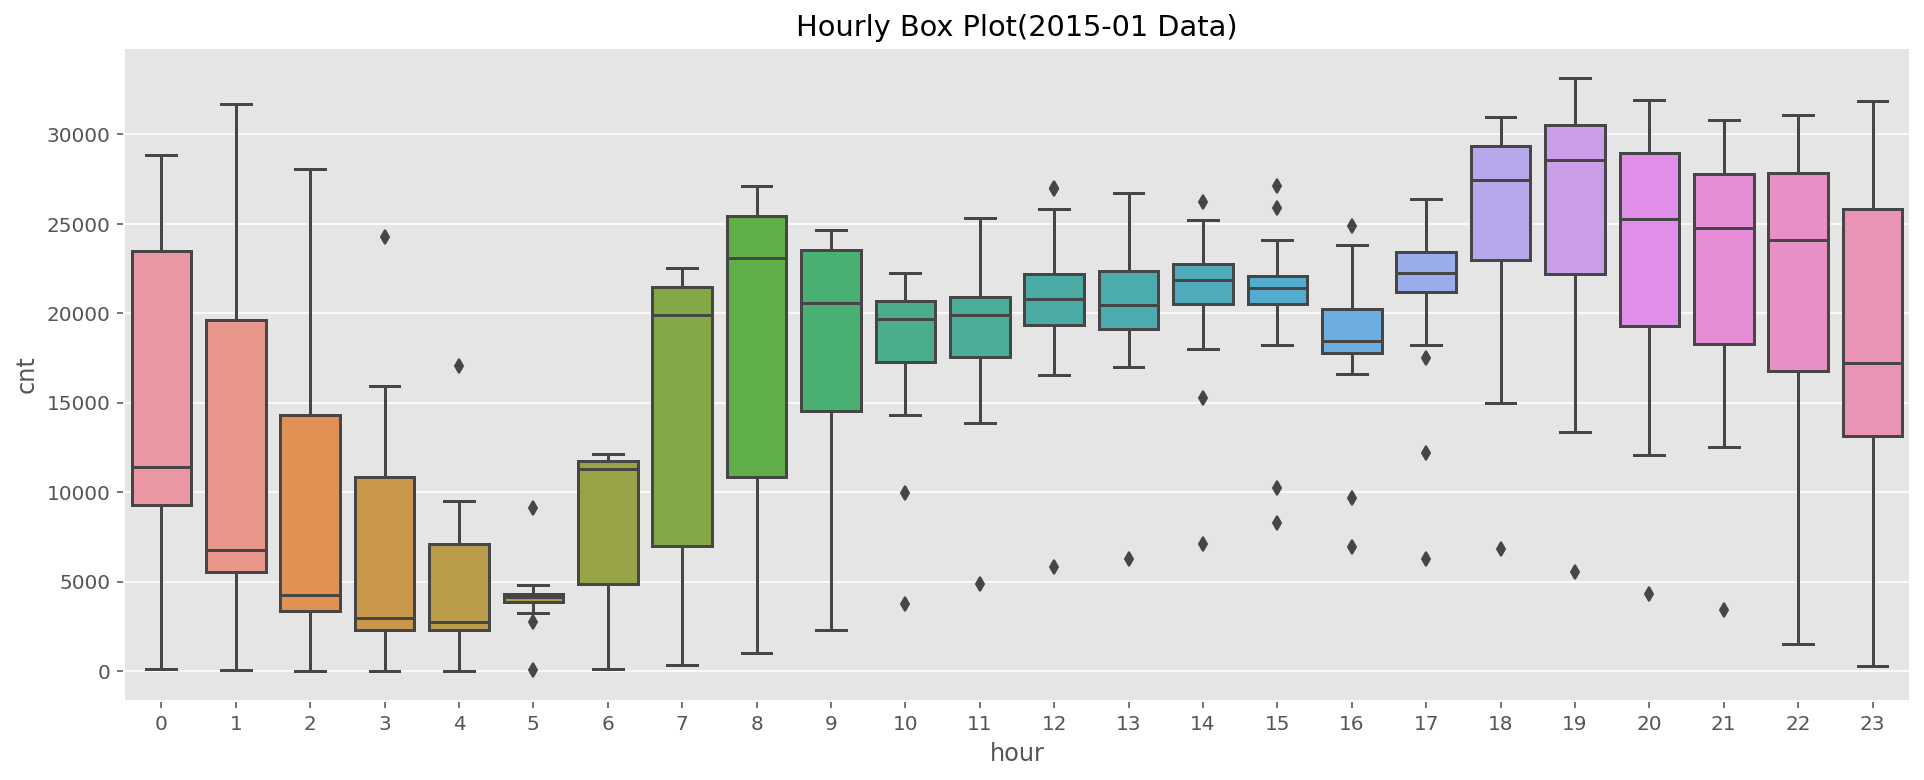

In [20]:
# 시간 별 Trip 빈도 수(일자 별 cnt 값에 따라 분포 생성)
plt.figure(figsize=(16, 6));
sns.boxplot(x='hour', y='cnt', data=df);
plt.title("Hourly Box Plot(2015-01 Data)")

Text(0.5, 1.0, 'Hourly Box Plot(Trip Count for first week on January, 2015)')

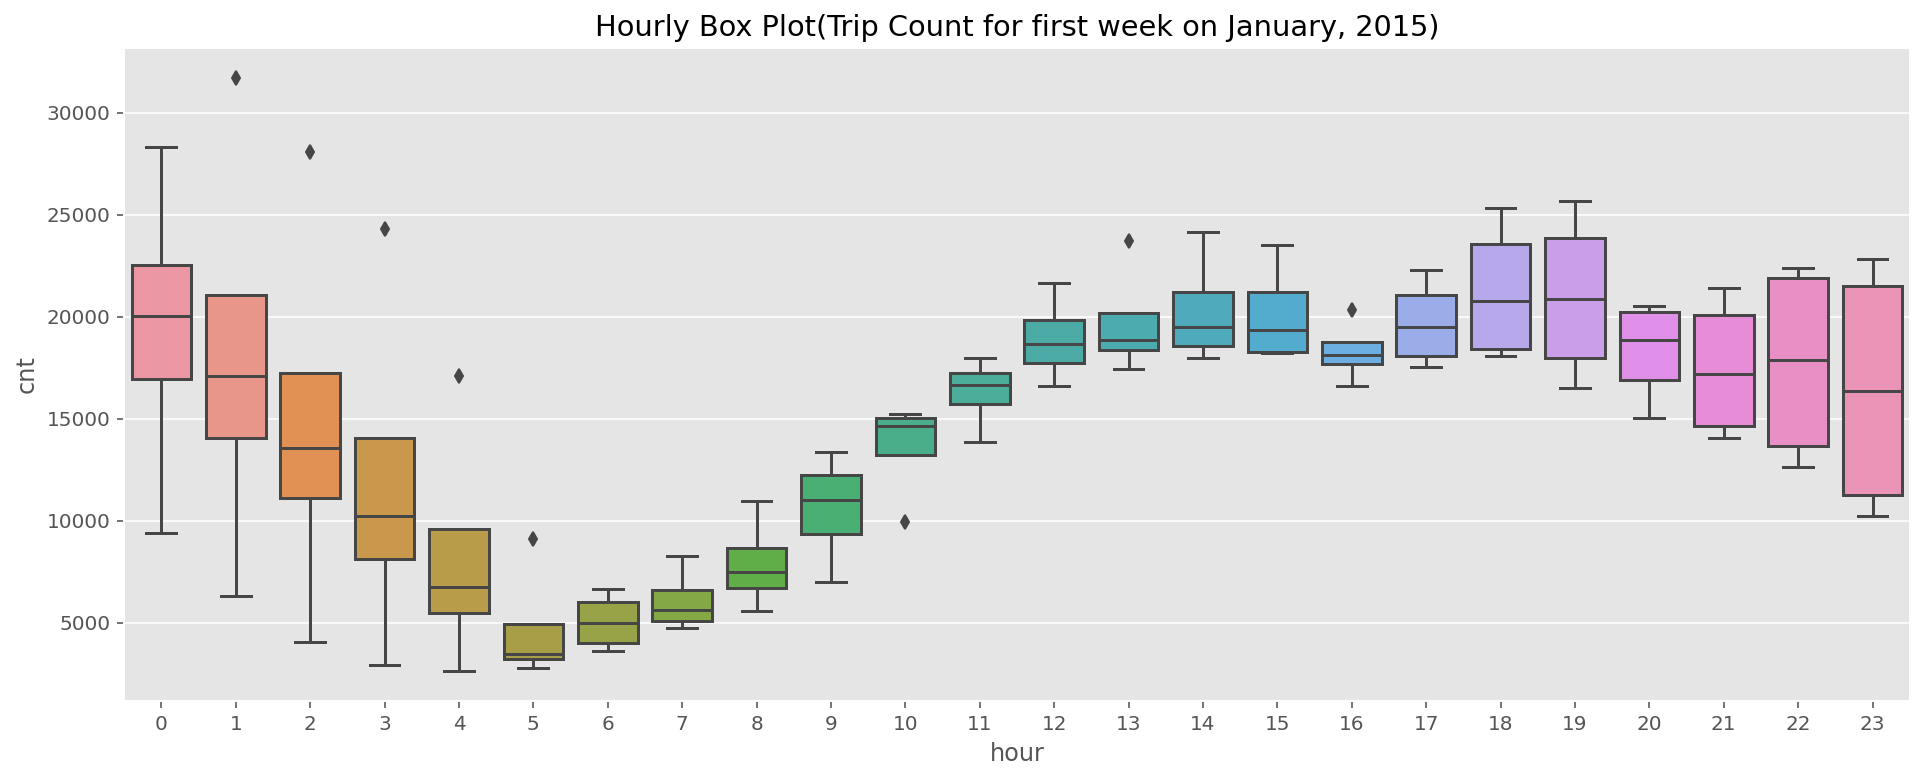

In [21]:
# 2015년 1월 1주차 시간 별 Trip 빈도 수
plt.figure(figsize=(16, 6))
sns.boxplot(x='hour', y='cnt', data=df[df['weeknum']==1])
plt.title("Hourly Box Plot(Trip Count for first week on January, 2015)")

Text(0.5, 1.0, 'Hourly Box Plot(Trip Count for second week on January, 2015)')

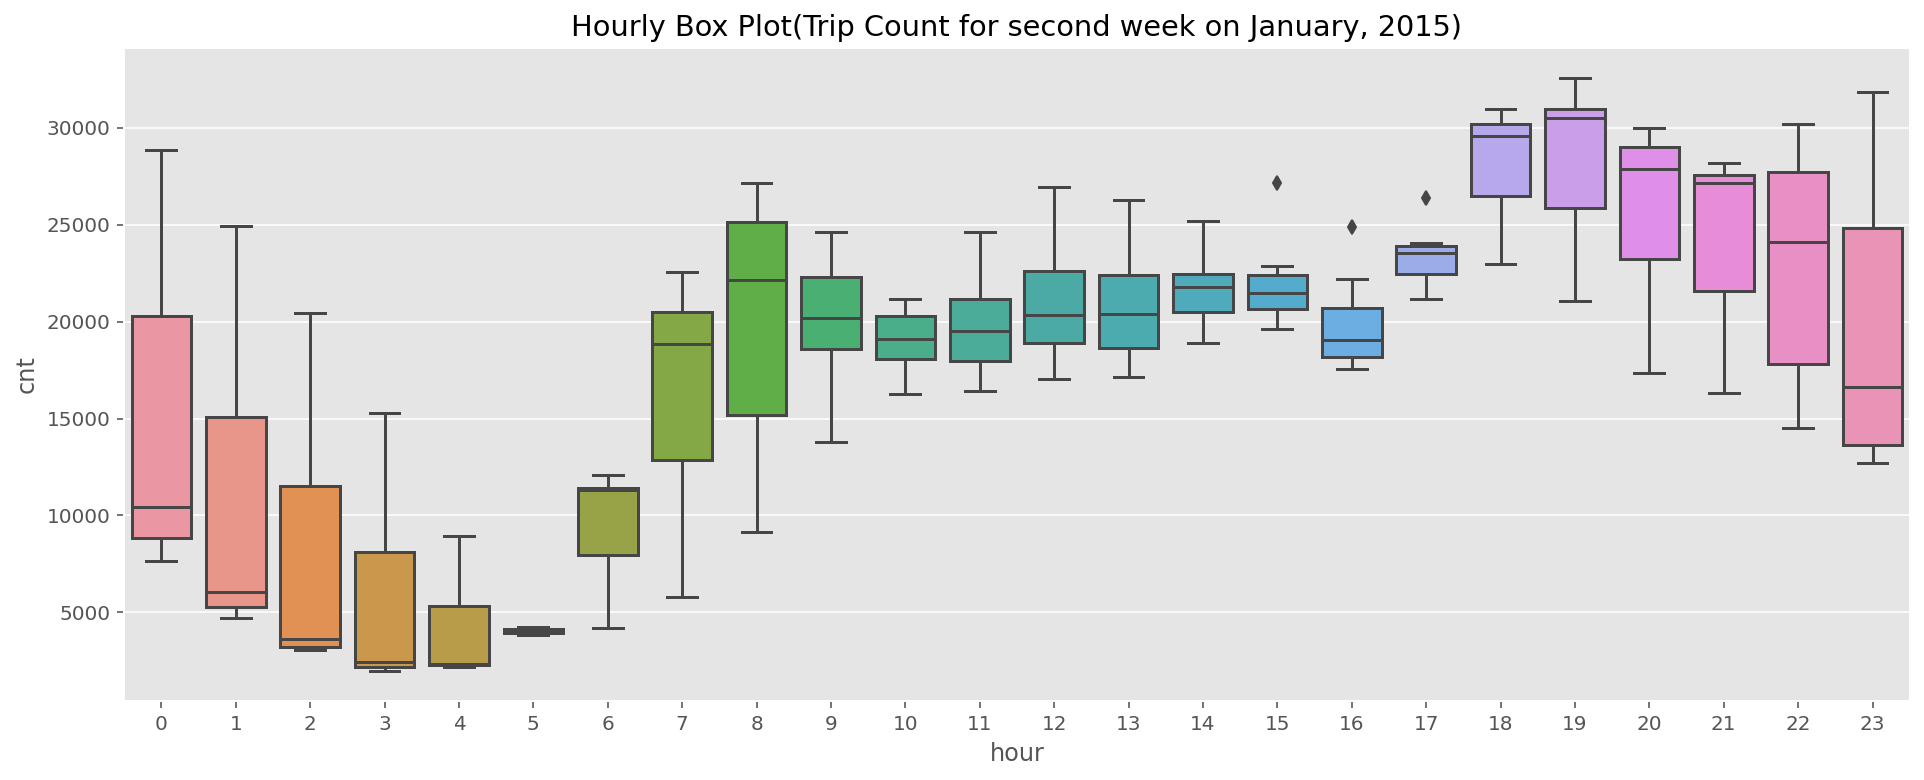

In [22]:
# 2015년 1월 2주차 시간 별 Trip 빈도 수
plt.figure(figsize=(16, 6))
sns.boxplot(x='hour', y='cnt', data=df[df['weeknum']==2])
plt.title("Hourly Box Plot(Trip Count for second week on January, 2015)")

In [23]:
# 1월의 각 주차마다, 시간 별 Trip 빈도 수를 boxplot으로 도식화해주는 함수
def visualize_hourly_boxplot_by_weeknum(df, y, weeknum):
    plt.figure(figsize=(16, 6))
    sns.boxplot(x='hour', y=y, data=df[df['weeknum']==weeknum])
    plt.title(f"Hourly Box Plot(Trip Count for 2015-1-{weeknum:02})")

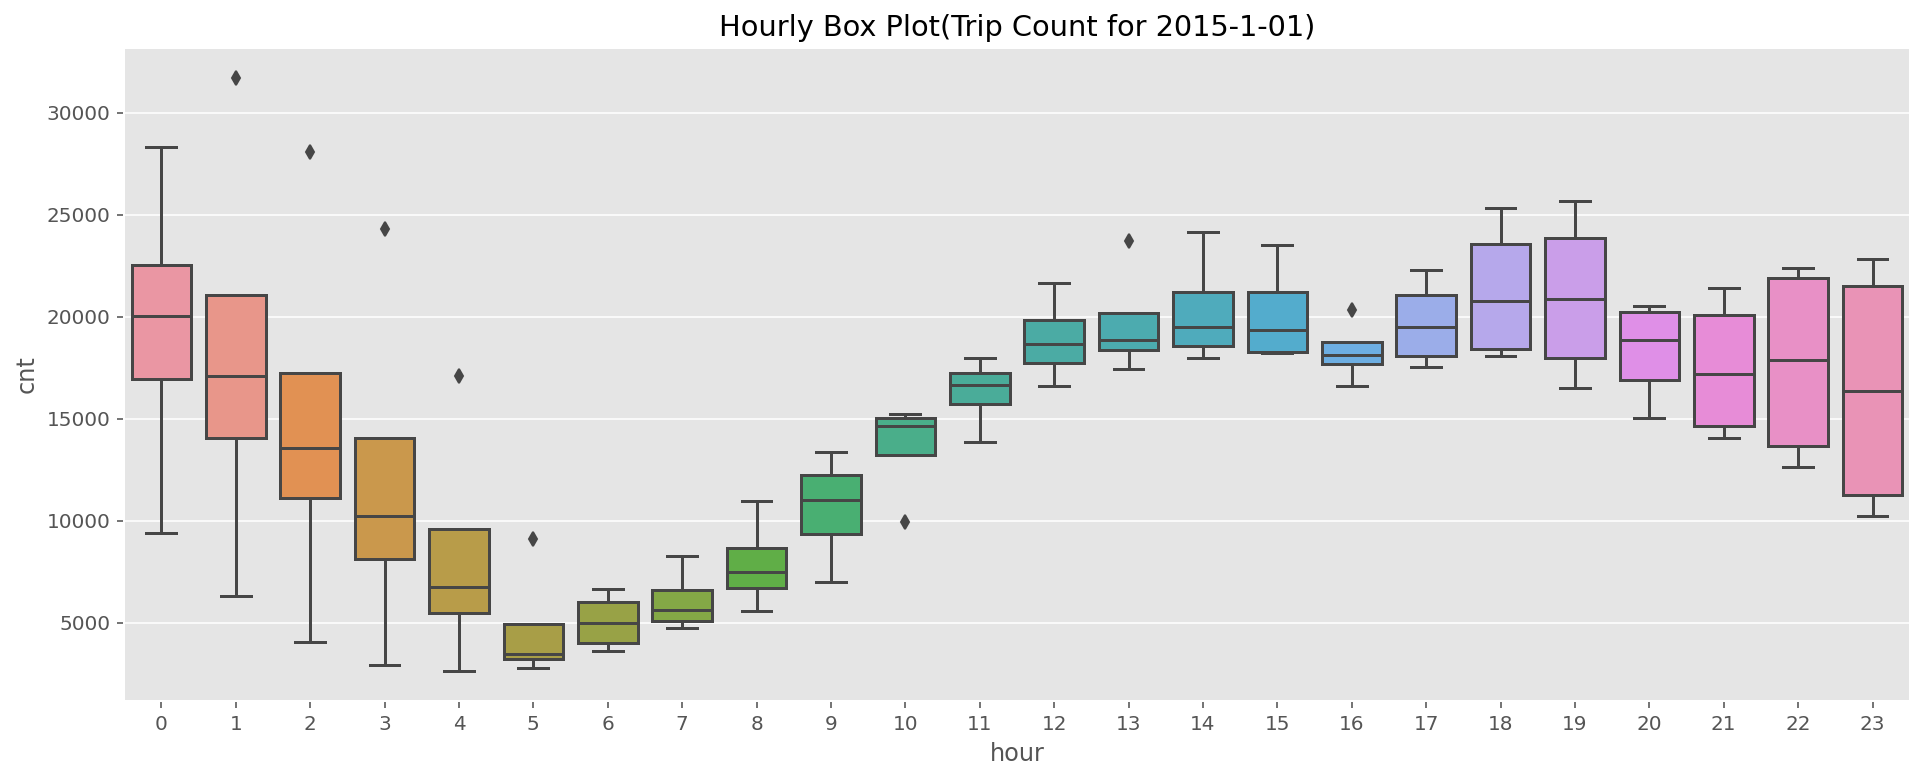

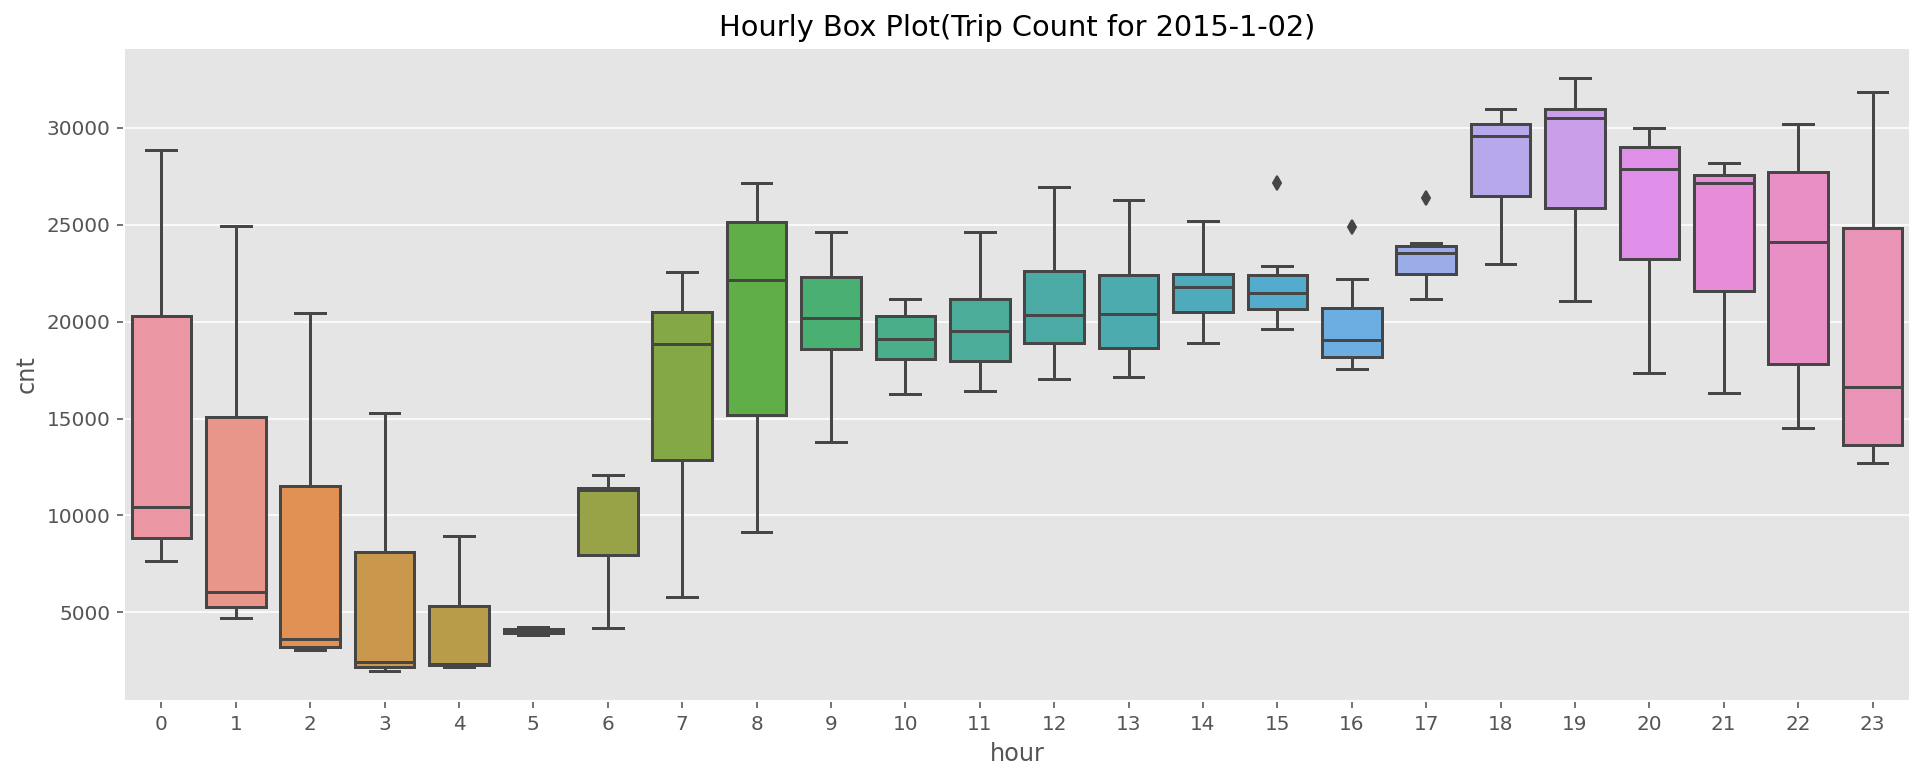

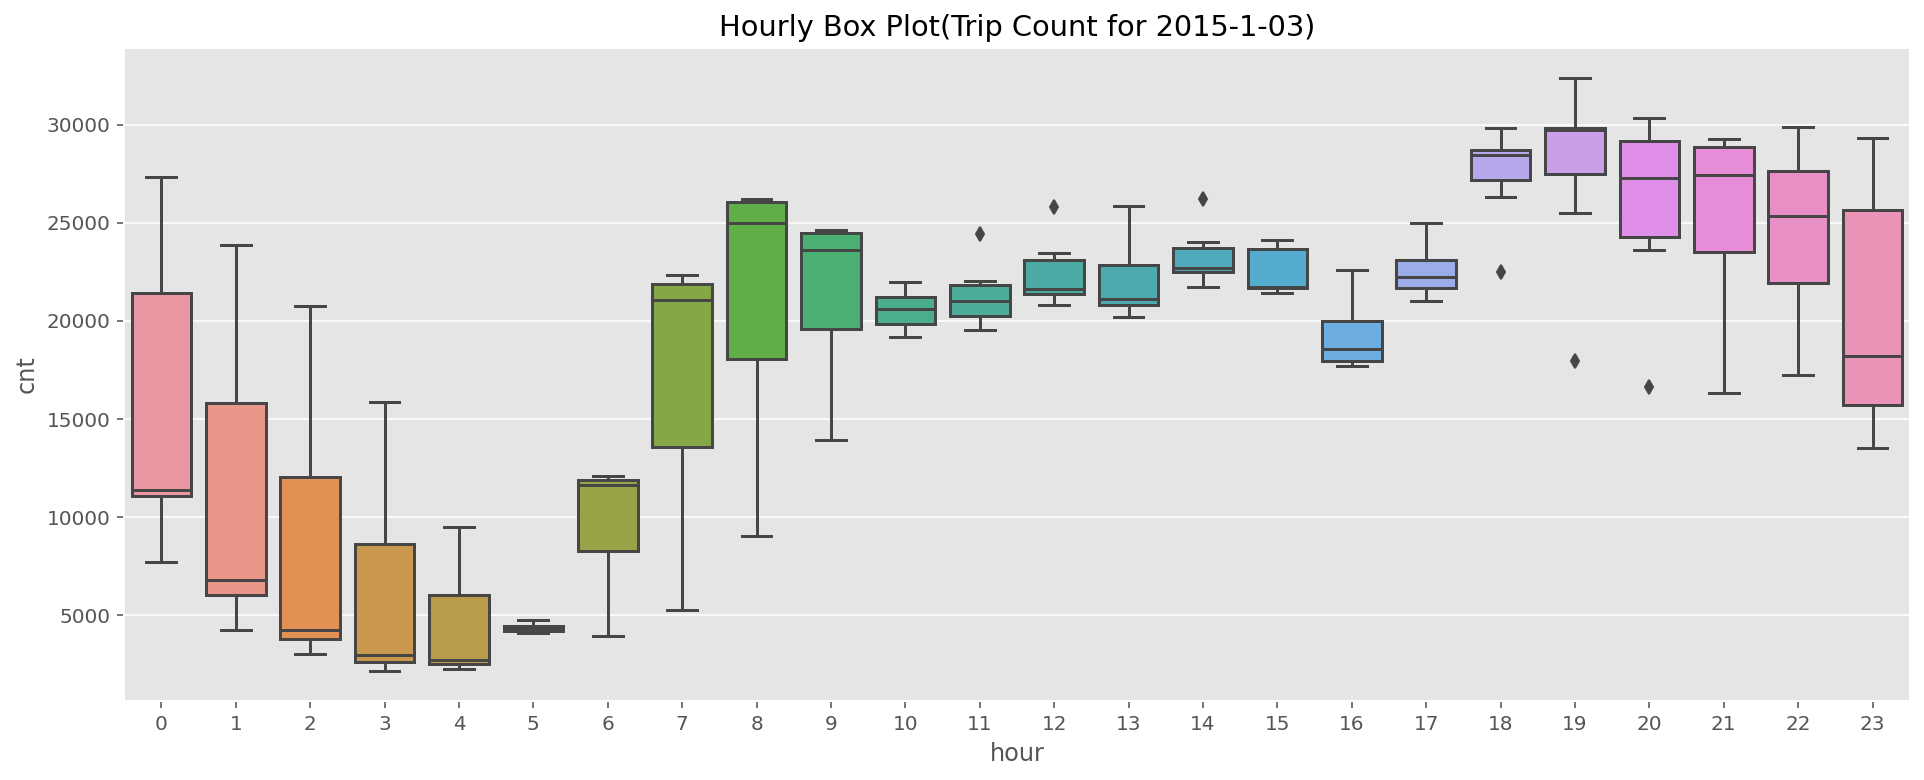

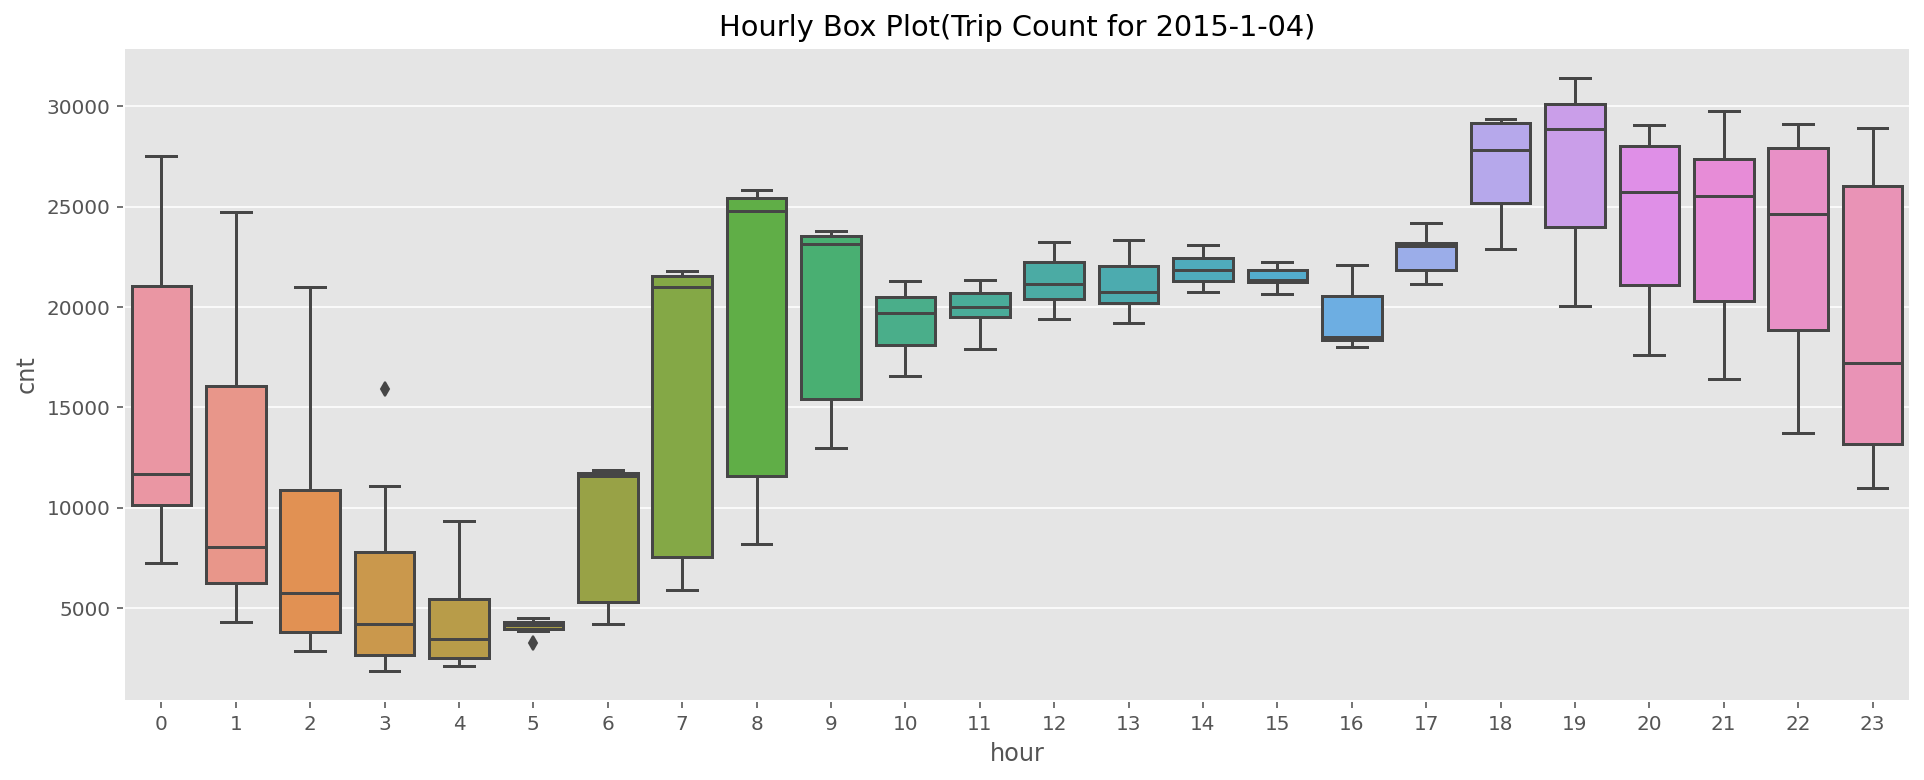

In [24]:
for week in range(1, 5):
    visualize_hourly_boxplot_by_weeknum(df, 'cnt', week)

### Viloinplot
- [Violin Plots 101](https://mode.com/blog/violin-plot-examples)

In [25]:
weekday_dict = {
    0:"Monday",
    1:"Tuesday",
    2:"Wednesday",
    3:"Thursday",
    4:"Friday",
    5:"Saturday",
    6:"Sunday"
}

In [26]:
# 2015년 1월 각 요일마다 시간 별 Trip 빈도 수를 Viloinplot으로 도식화
def visualize_violinplot_by_weekday(df, y, weekday):
    plt.figure(figsize=(16, 6));
    sns.violinplot(x="hour", y=y, hue="weekday", 
                   data=df[df['weekday'] == weekday][['hour', 'weekday', y]],
                   inner="quart");    
    plt.title(f"{weekday_dict[weekday]}'s hourly violinplot {y}(2015-01 Data)")

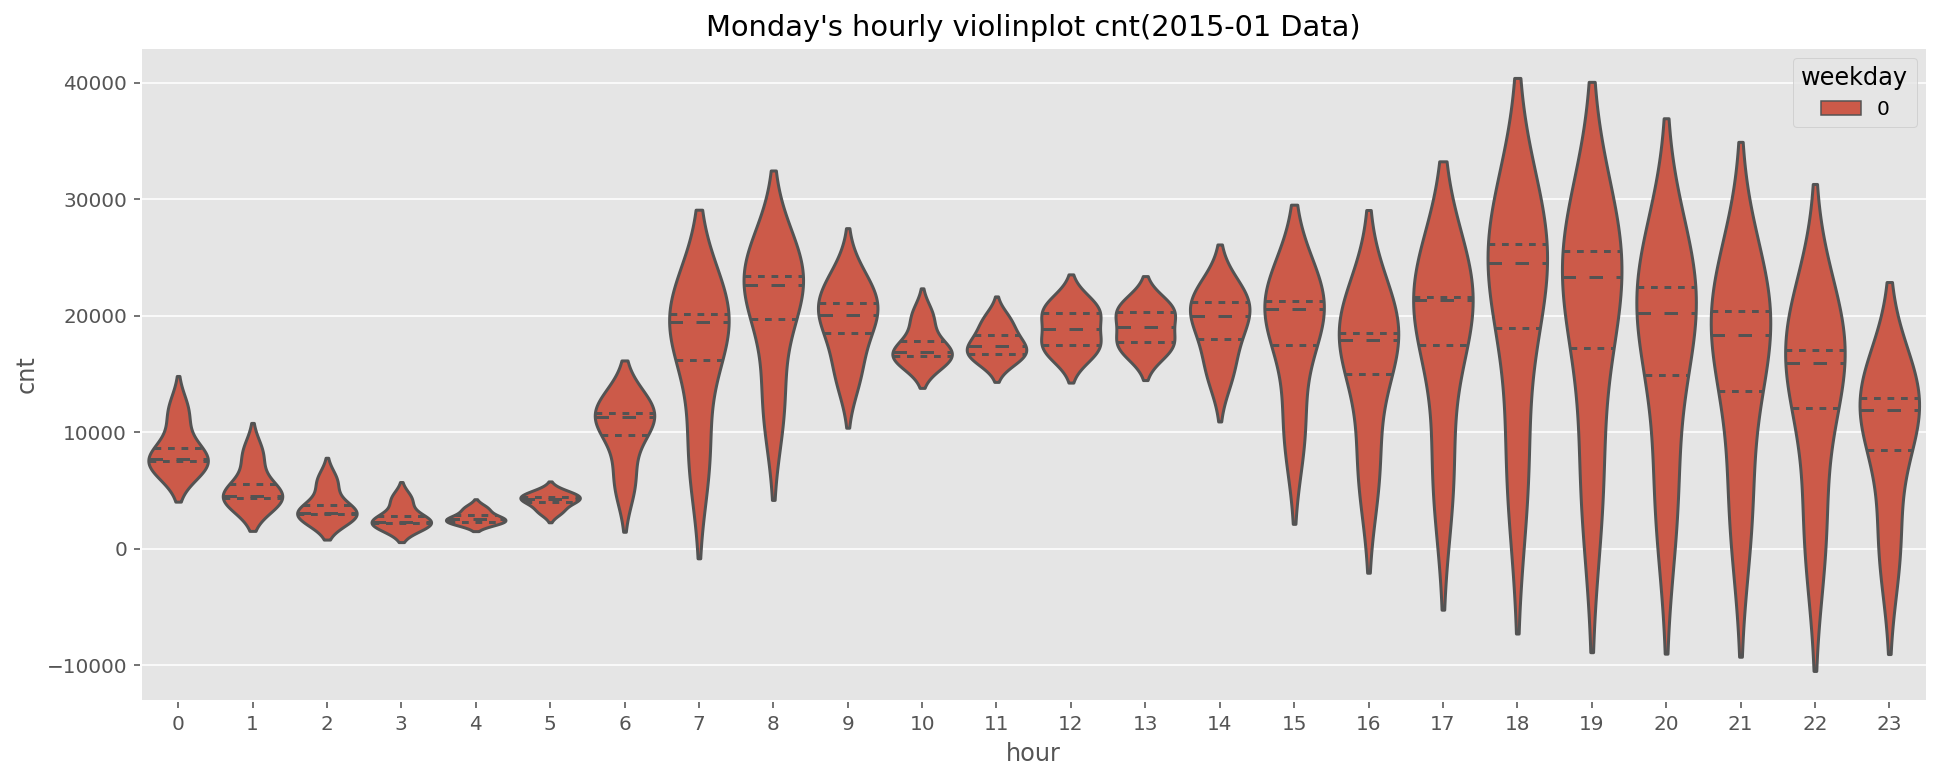

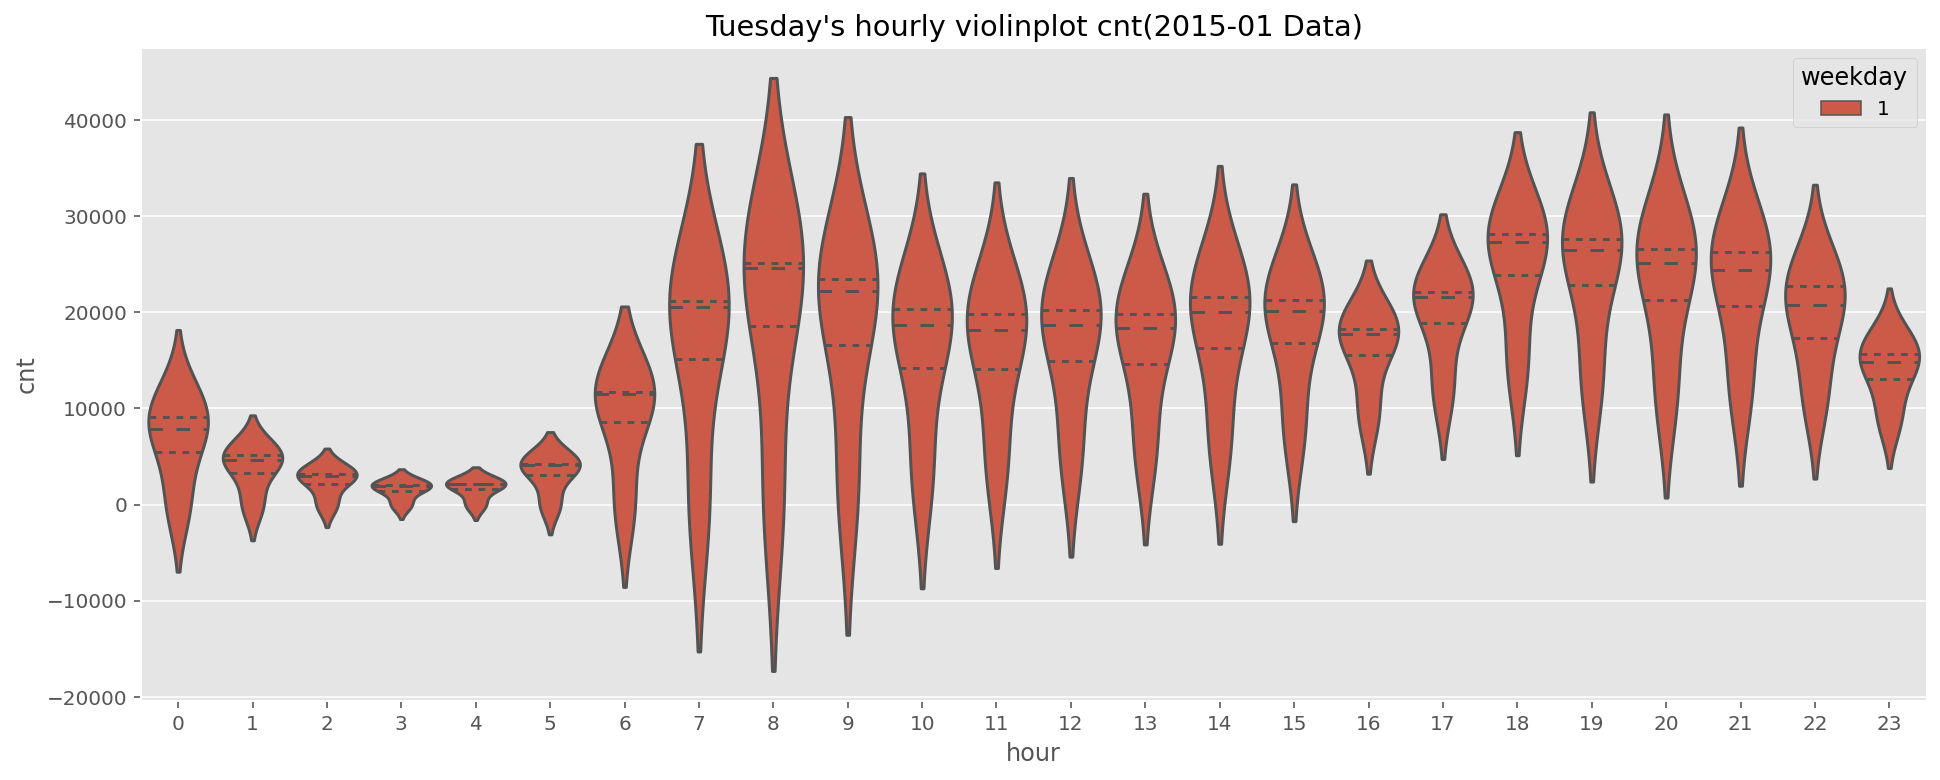

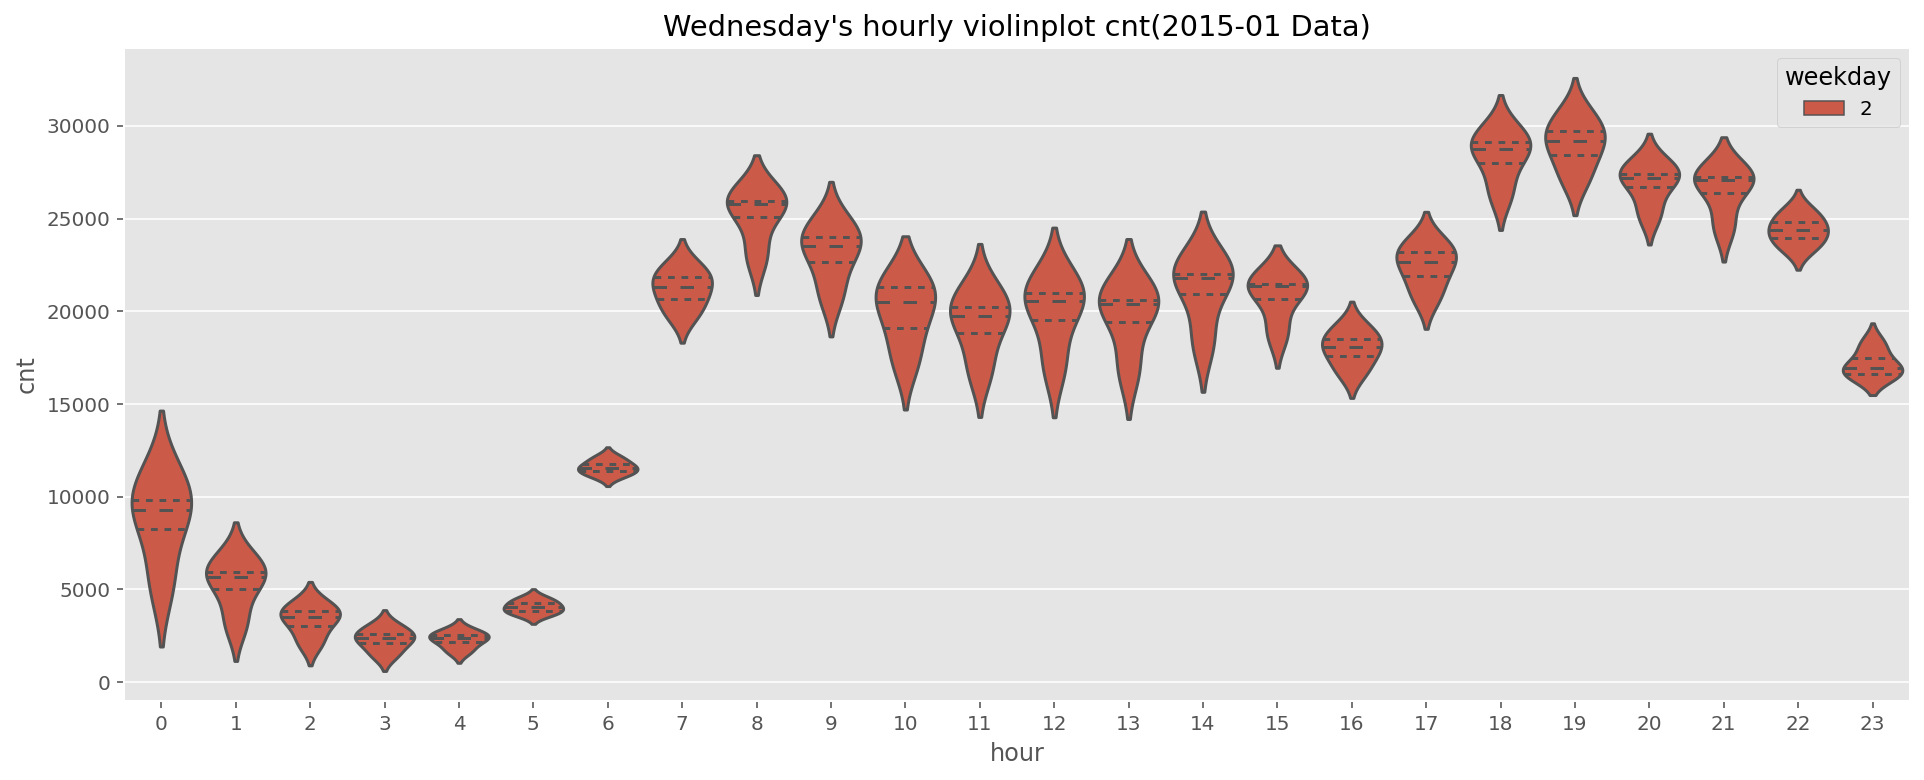

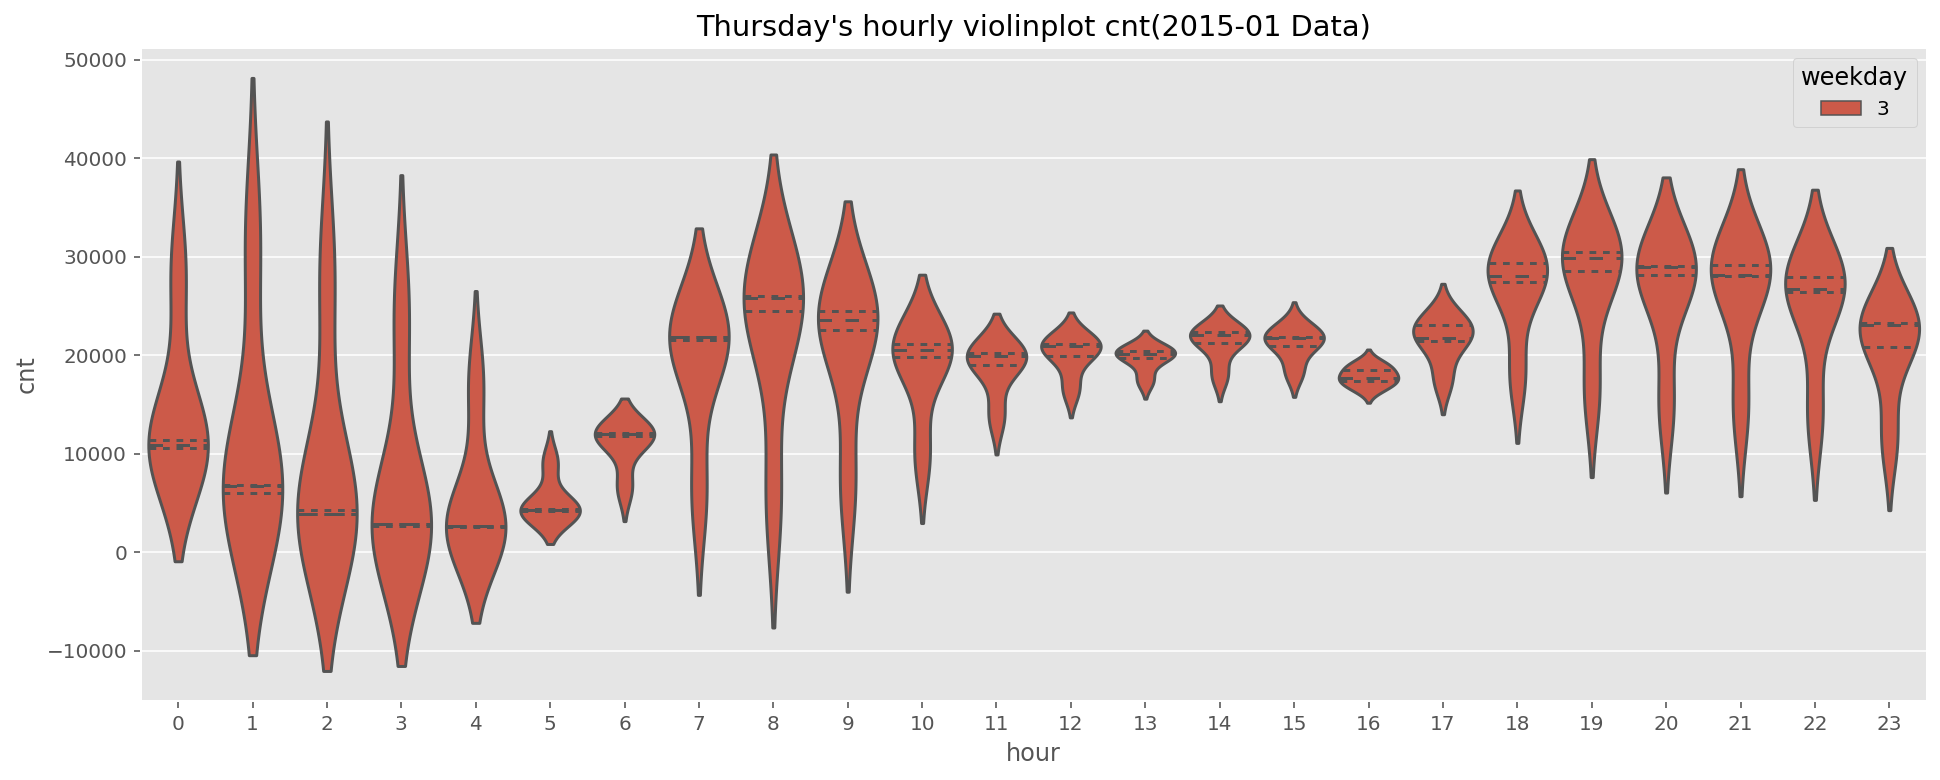

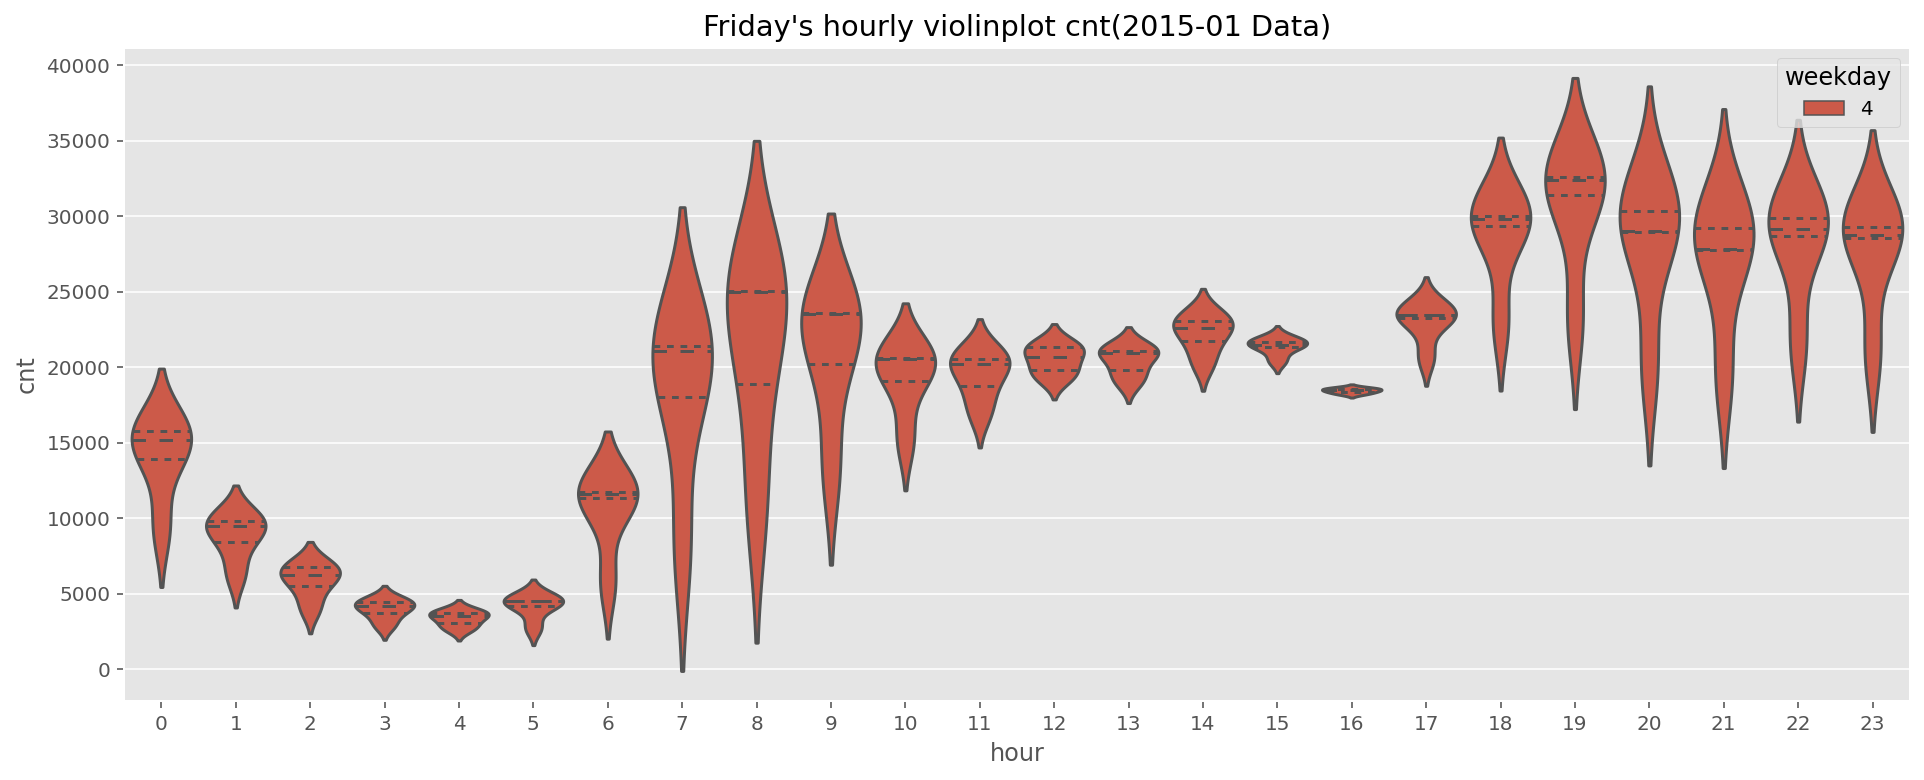

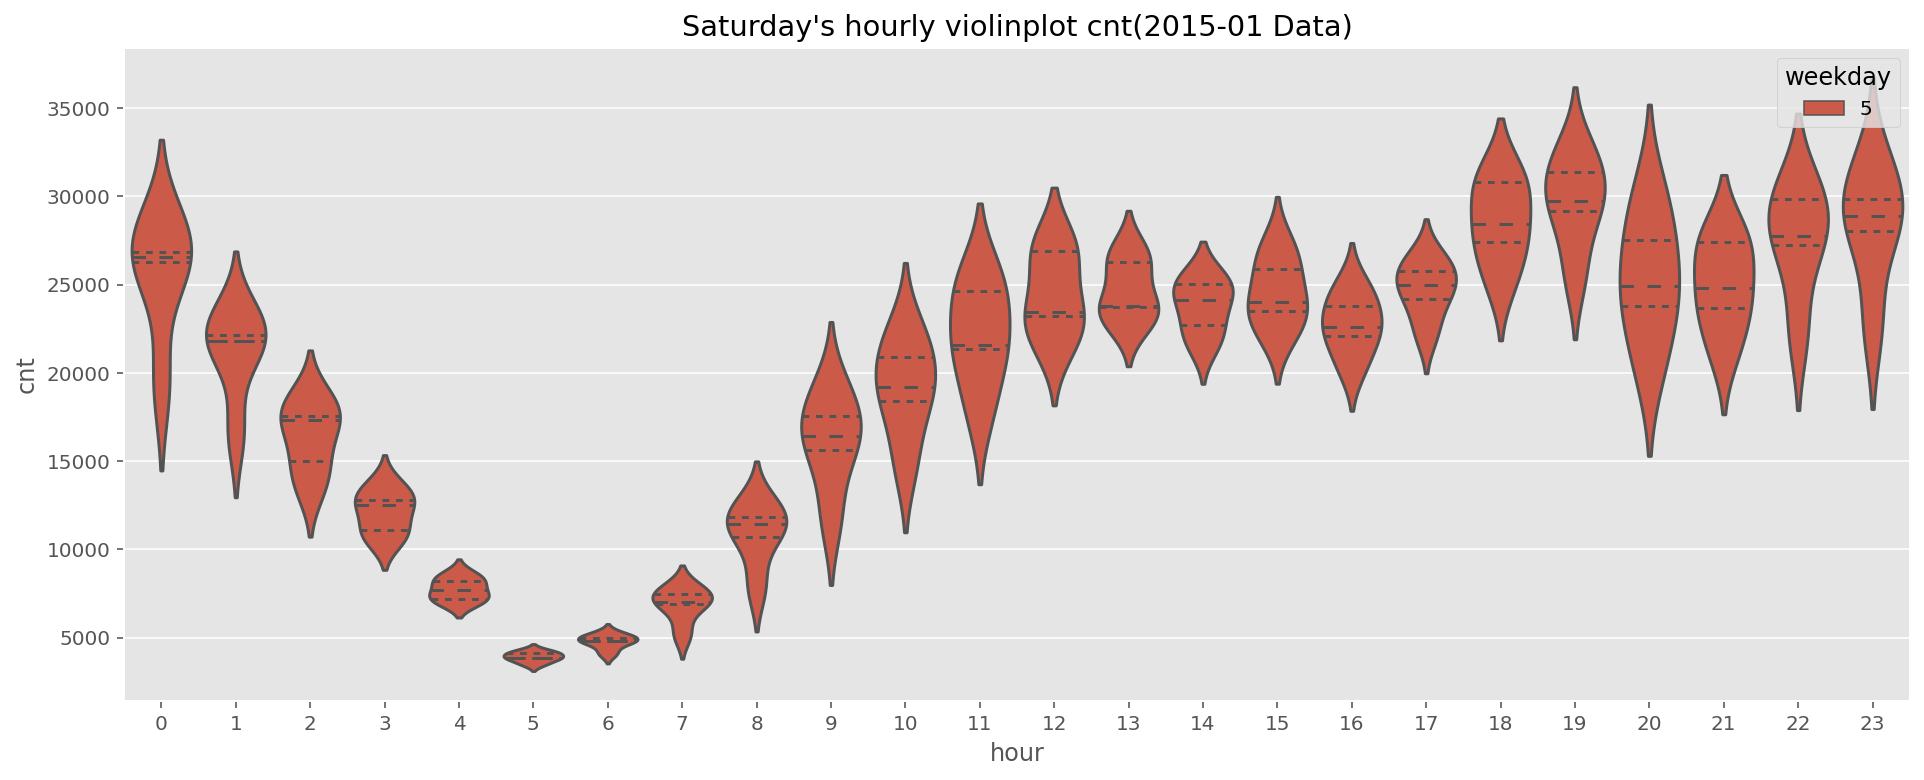

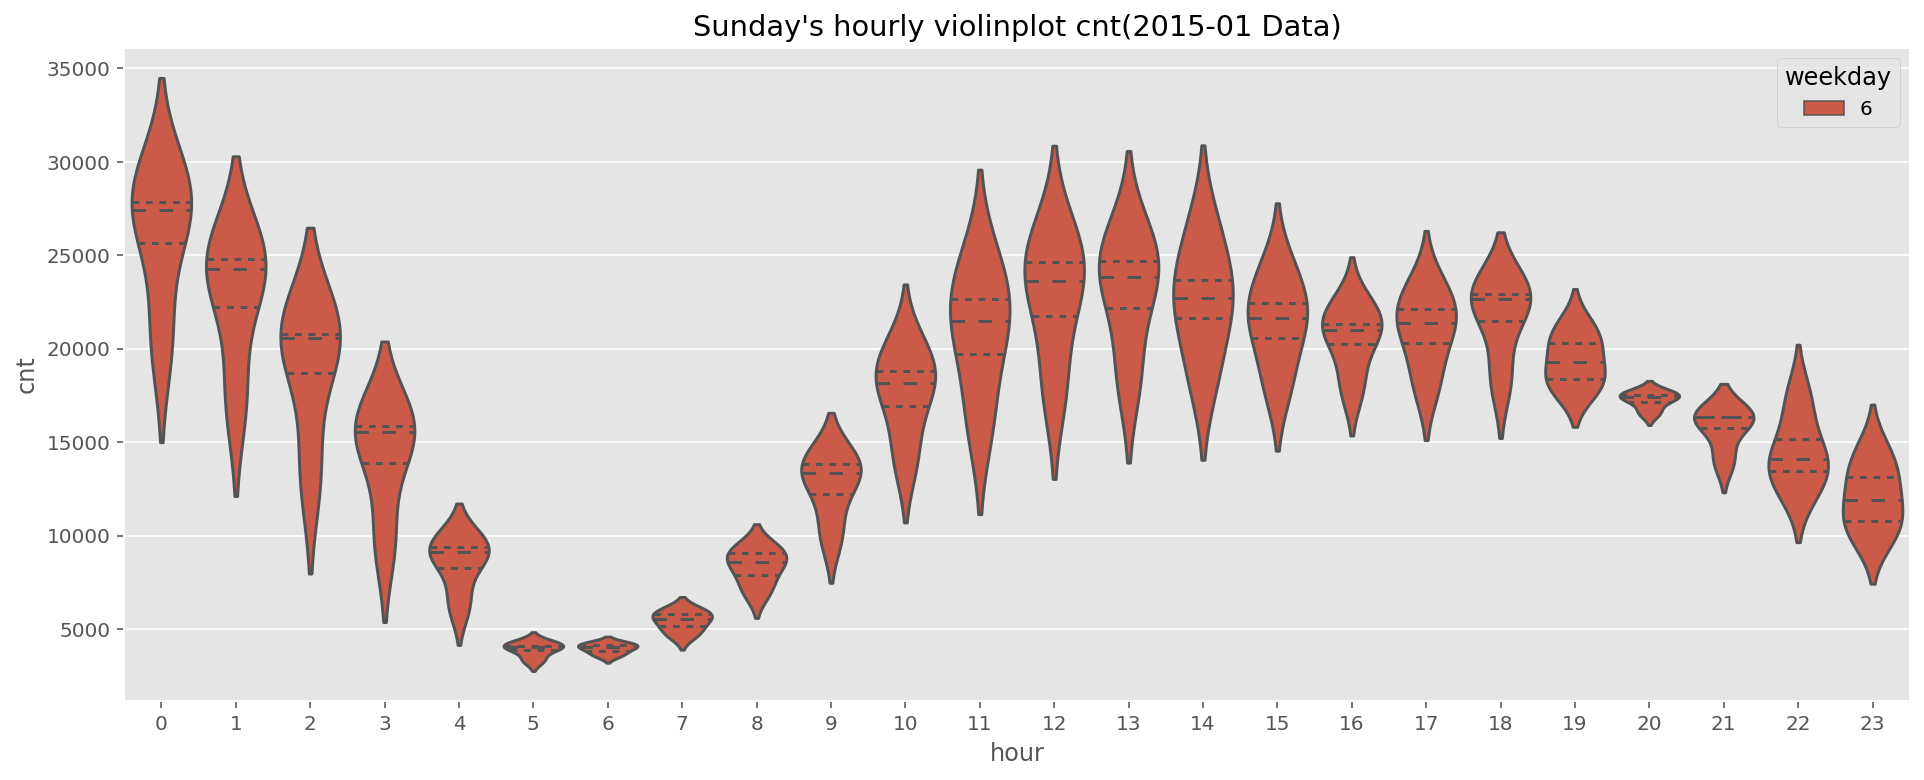

In [27]:
for weekday in range(0, 6+1):
    visualize_violinplot_by_weekday(df, 'cnt', weekday)

### Trip distance 분포

In [28]:
%%time

#  Trip distance를 30km 단위로 bucket flooring 함. ex) 0 ~ 29km : 0, 30 ~ 59km : 30
#  2015년 1월의 Trip distance 분포를 확인하는 쿼리
trip_distance_query = """
SELECT 
    floor(trip_distance/30)*30 as bucket_floor,
    count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY bucket_floor
order by bucket_floor
"""


# Trip distance count를 log 처리한 부분을 제외하면, 위 쿼리와 기능은 동일
trip_distance_query_log = """
SELECT 
    floor(trip_distance/30)*30 as bucket_floor,
    log10(count(*)) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY bucket_floor
order by bucket_floor
"""

distance_df = pd.read_gbq(query=trip_distance_query, dialect='standard', project_id='nyc-taxi-demand')
distance_log_df = pd.read_gbq(query=trip_distance_query_log, dialect='standard', project_id='nyc-taxi-demand')

Downloading: 100%|██████████████████████████| 57/57 [00:00<00:00, 182.68rows/s]

Wall time: 7.97 s


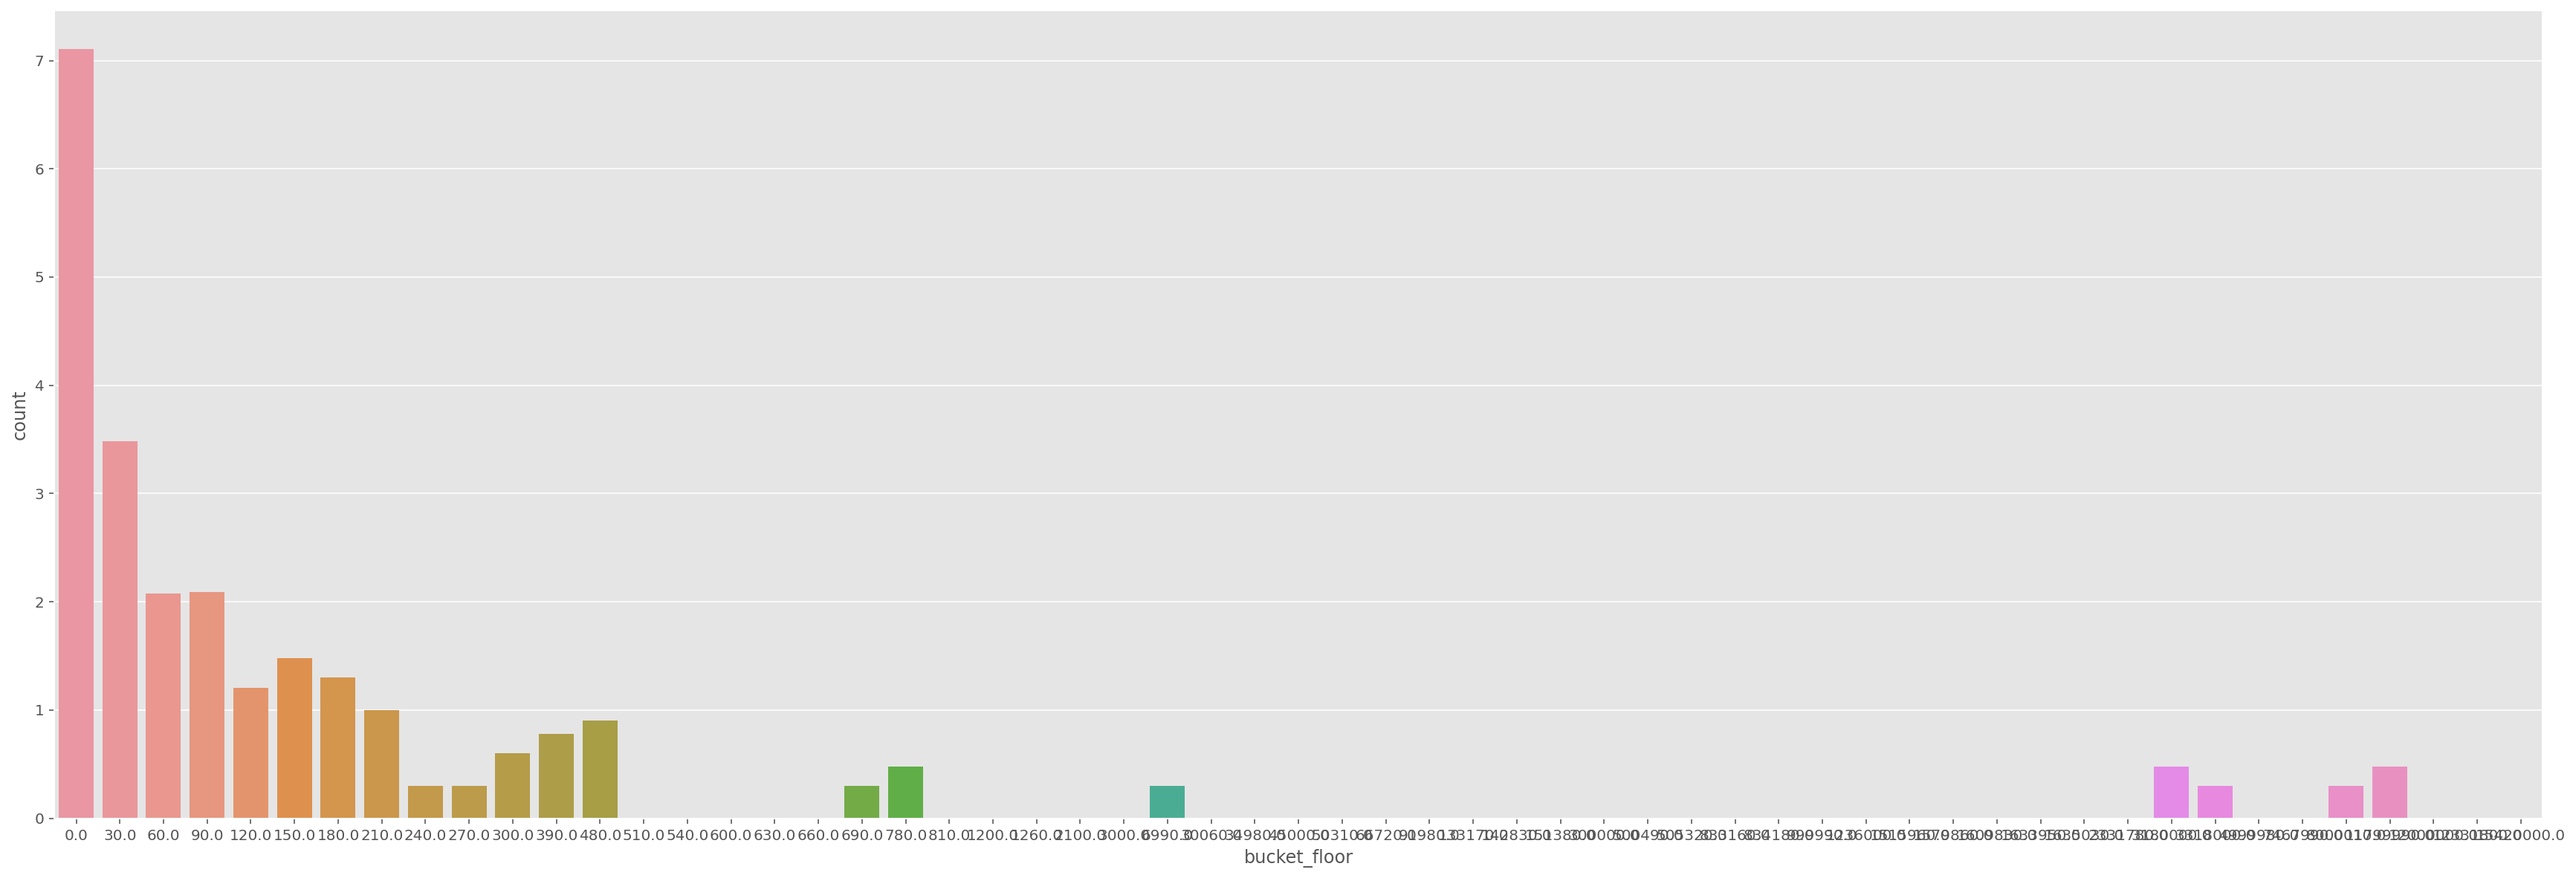

In [34]:
plt.figure(figsize=(30, 10))
sns.barplot(x=distance_log_df['bucket_floor'], y=distance_log_df['count'])

- 단거리 운행(0 ~ 30km) 횟수가 압도적으로 많음을 확인할 수 있음

In [36]:
distance_df.head(10)

,bucket_floor,count
0,0.0,12745563
1,30.0,3027
2,60.0,120
3,90.0,124
4,120.0,16
5,150.0,30
6,180.0,20
7,210.0,10
8,240.0,2
9,270.0,2


### 장거리/단거리 수요
- 시간대별 장거리/단거리 수요

In [37]:
%%time

short_trip_query = """
SELECT 
  EXTRACT(HOUR FROM pickup_datetime) as pickup_hour,
  EXTRACT(HOUR FROM dropoff_datetime) as dropoff_hour,
  count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
and trip_distance < 30
GROUP BY pickup_hour, dropoff_hour
"""

short_trip_df = pd.read_gbq(query=short_trip_query, dialect='standard', project_id='nyc-taxi-demand')

Downloading: 100%|███████████████████████| 339/339 [00:00<00:00, 1021.03rows/s]

Wall time: 4.39 s


In [38]:
%%time

long_trip_query = """
SELECT 
  EXTRACT(HOUR FROM pickup_datetime) as pickup_hour,
  EXTRACT(HOUR FROM dropoff_datetime) as dropoff_hour,
  count(*) as count
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
and trip_distance >= 30
GROUP BY pickup_hour, dropoff_hour
"""

long_trip_df = pd.read_gbq(query=long_trip_query, dialect='standard', project_id='nyc-taxi-demand')

Downloading: 100%|████████████████████████| 115/115 [00:00<00:00, 379.52rows/s]

Wall time: 3.54 s


In [39]:
short_trip_df

,pickup_hour,dropoff_hour,count
0,15,15,510697
1,17,18,154322
2,9,9,457809
3,19,19,653731
4,16,16,456065
...,...,...,...
334,9,19,1
335,19,6,1
336,5,12,1
337,2,11,1


In [40]:
long_trip_df

,pickup_hour,dropoff_hour,count
0,15,17,47
1,20,21,113
2,18,19,114
3,18,18,26
4,0,1,102
...,...,...,...
110,10,14,1
111,13,17,1
112,9,8,1
113,22,1,1


In [41]:
# merge dataframe
trip_df = short_trip_df.merge(long_trip_df, on=["pickup_hour", "dropoff_hour"], suffixes=["_short", "_long"]) \
                       .rename(columns={"count_short":"short_trips", "count_long":"long_trips"})

In [42]:
trip_df.head(10)

,pickup_hour,dropoff_hour,short_trips,long_trips
0,15,15,510697,38
1,17,18,154322,132
2,9,9,457809,12
3,19,19,653731,30
4,16,16,456065,27
5,0,0,385730,26
6,8,8,435904,11
7,10,11,117935,96
8,14,14,511868,28
9,2,3,45314,60


In [43]:
# 승차 시각, 하차 시각을 기준으로 하여, short trip 빈도와 long trip 빈도를 합산한 데이터프레임 생성
trip_df_pickup = trip_df.groupby(["pickup_hour"], as_index=False).agg({'short_trips':'sum', 'long_trips':'sum'}) \
                                                                      .sort_values(by="pickup_hour")
trip_df_dropoff = trip_df.groupby(["dropoff_hour"], as_index=False).agg({'short_trips':'sum', 'long_trips':'sum'}) \
                                                                      .sort_values(by="dropoff_hour")

In [44]:
trip_df_pickup

,pickup_hour,short_trips,long_trips
0,0,469713,146
1,1,354890,94
2,2,267918,89
3,3,198414,59
4,4,143109,62
5,5,127230,75
6,6,268293,95
7,7,455724,151
8,8,561489,120
9,9,579788,124


In [45]:
trip_df_dropoff

,dropoff_hour,short_trips,long_trips
0,0,494882,149
1,1,377049,147
2,2,284456,100
3,3,208594,81
4,4,156581,57
5,5,121249,58
6,6,235684,79
7,7,413314,89
8,8,537410,122
9,9,583947,119


### 승/하차, 장/단거리 운행 별로 시간에 따른 Trip 빈도 수를 시계 형식으로 도식화

In [46]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # 24시간을 위한 theta 생성
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # plot의 각각의 bin width 지정
    width = 2*np.pi / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # label을 시계 방향으로 설정하고 위에서 시작
    ax.set_theta_zero_location("N")
    # 시계 방향 설정
    ax.set_theta_direction(-1)

    # label 설정
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

In [47]:
def diff_short_long_trip_on_time(trip_df_pickup, trip_df_dropoff):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

    # 2, 2의 첫번째에 그림
    ax = plt.subplot(2,2,1, polar=True)
    # 24시간의 각각의 bin에 히스토그램 그림
    radii = np.array(trip_df_pickup['short_trips'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    # 2, 2의 두번째에 그림
    ax = plt.subplot(2,2,2, polar=True)
    # 24시간의 각각의 bin에 히스토그램 그림
    radii = np.array(trip_df_pickup['long_trips'].tolist(), dtype="int64")
    title = "Pickup Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

    ax = plt.subplot(2,2,3, polar=True)
    radii = np.array(trip_df_dropoff['short_trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,4, polar=True)
    radii = np.array(trip_df_dropoff['long_trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

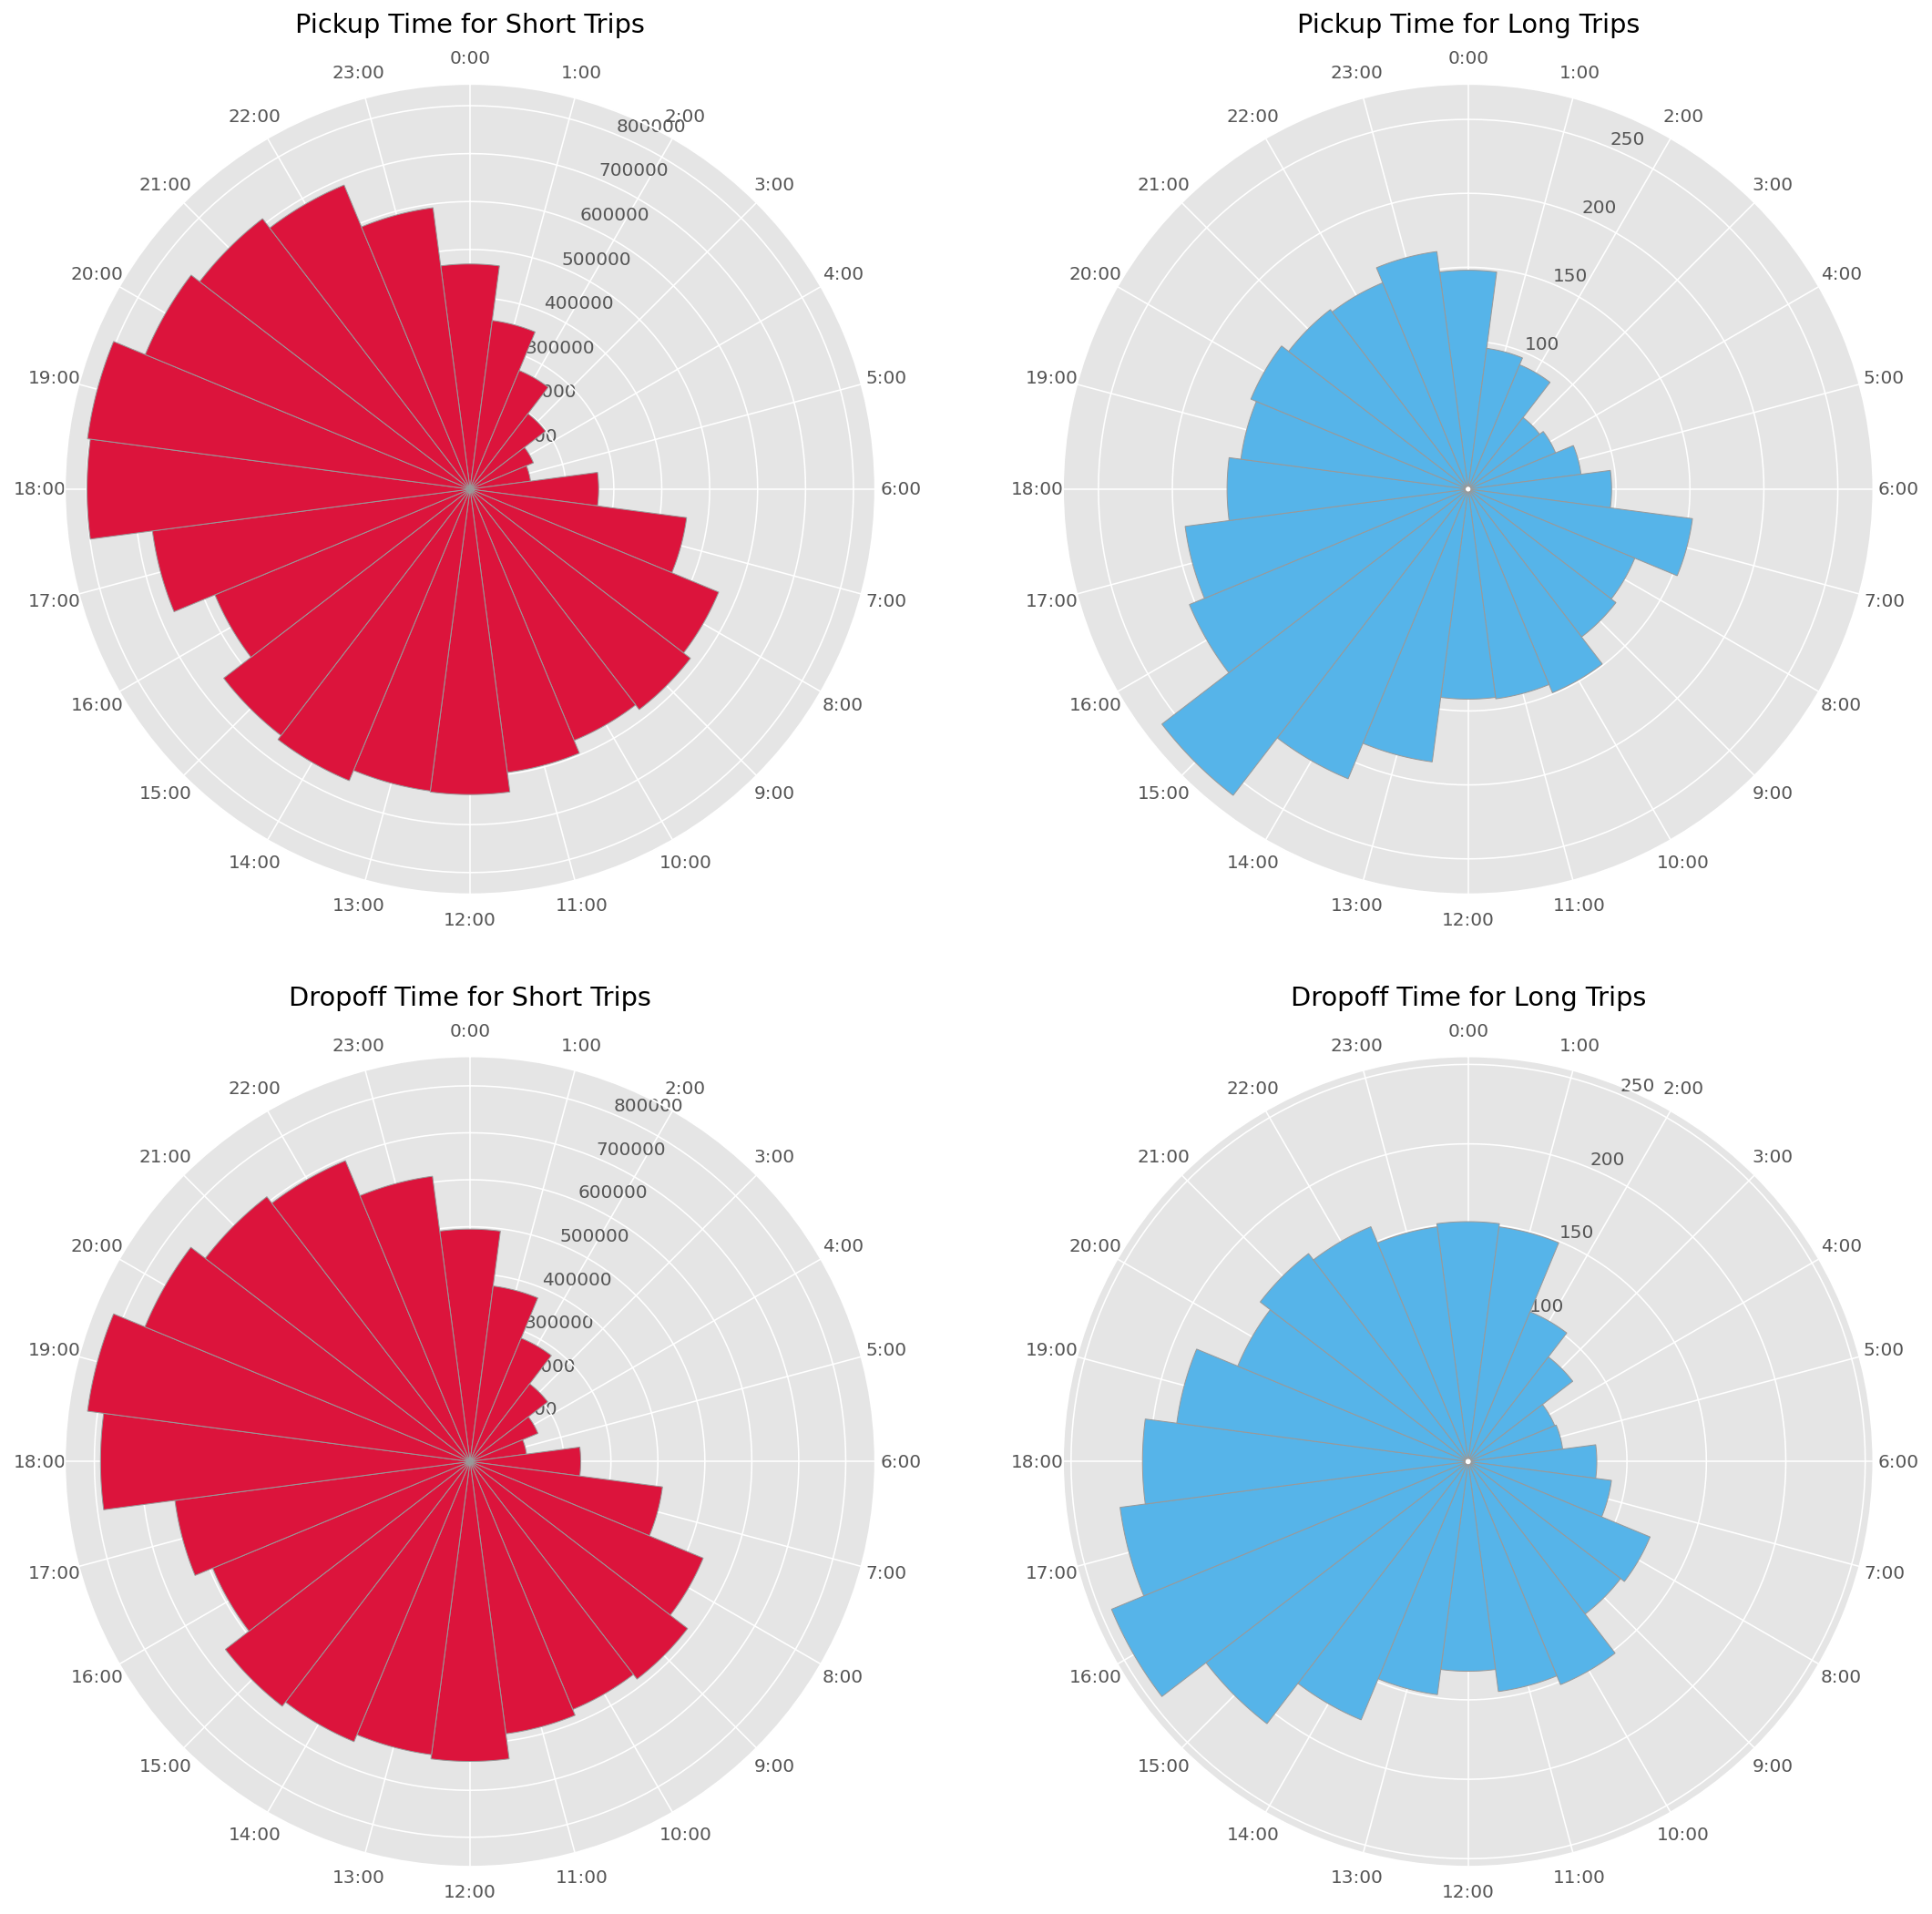

In [48]:
diff_short_long_trip_on_time(trip_df_pickup, trip_df_dropoff)